In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import colors
import random

In [2]:
df = pd.read_csv('agent_1_data.csv')

In [3]:
c = []
x_train = []
for i in range(len(df)):
    arr = np.fromstring(df['x'][i].replace('[', '').replace(']', ''), dtype=int, sep='\n').reshape(3,3)
    arr = arr/arr.max()
    c.append(np.asarray(arr))
x_train = np.asarray(c)
x_train = np.asarray(x_train)
x_train.shape

(29162, 3, 3)

In [4]:
out = []
for i in range(len(df)):
    a = df['y'][i].replace('[', '').replace(']', '').replace(',','').split()
    a = [int(m) for m in a]
    out.append(np.asarray(a))
y_train = out
y_train = np.asarray(out)
y_train

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [5]:
a = []
for i in (y_train):
    row = list(i).index(1)
    a.append(row)
y_train = np.asarray(a)

y_train[0]

0

In [6]:
sequential is the basic model
model = tf.keras.models.Sequential()

# we add hidden layers into our network. 128 is the number of neurons that we use
# relu is a basic activation sigmoid function
# softmax is used for probability distribution (used in final/output layer with 10 neurons)
# we reduce 28x28 array to a flatten layer as it is multidimensional and hard to compute
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(4, activation = tf.nn.softmax))

parameters for training for the model

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# model = tf.keras.models.load_model(
#     'epic_num_reader.model', custom_objects=None, compile=True, options=None
# )

print('x_train', x_train.shape)
print('\ny_train', y_train.shape)

callback = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
model.fit(x_train, y_train, epochs=10,callbacks=[callback])

x_train (29162, 3, 3)

y_train (29162,)
Epoch 1/10
912/912 [==============================] - 2s 2ms/step - loss: 0.1345 - accuracy: 0.9449
Epoch 2/10
912/912 [==============================] - 1s 1ms/step - loss: 0.1337 - accuracy: 0.9451
Epoch 3/10
912/912 [==============================] - 1s 1ms/step - loss: 0.1335 - accuracy: 0.9448
Epoch 4/10
912/912 [==============================] - 1s 1ms/step - loss: 0.1377 - accuracy: 0.9439
Epoch 5/10
912/912 [==============================] - 1s 1ms/step - loss: 0.1337 - accuracy: 0.9449
Epoch 6/10
912/912 [==============================] - 1s 1ms/step - loss: 0.1334 - accuracy: 0.9452
Epoch 7/10
912/912 [==============================] - 1s 1ms/step - loss: 0.1350 - accuracy: 0.9441
Epoch 8/10
912/912 [==============================] - 1s 2ms/step - loss: 0.1334 - accuracy: 0.9451
Epoch 9/10
912/912 [==============================] - 1s 1ms/step - loss: 0.1340 - accuracy: 0.9447
Epoch 10/10
912/912 [==============================] - 1s 2m

In [7]:
# calculate the validation loss
val_loss, val_accuracy = model.evaluate(x_train, np.asarray(y_train))
print(val_loss, val_accuracy)

912/912 [==============================] - 1s 1ms/step - loss: 0.1327 - accuracy: 0.9447
0.13268649578094482 0.944722592830658


In [8]:
model.save('epic_num_reader.model')

INFO:tensorflow:Assets written to: epic_num_reader.model\assets


In [9]:
def get_children(x, y, n, visited_list):
    """
    This function is used to return children of a particular node
    x: row value of current node
    y: column value of current node
    n: size of maze
    gofn: g(n) value of current node
    visited_list: list of nodes that are already visited
    matrix: maze
    agent_matrix: matrix of the agent that holds the information of updated environment
    """
    allChildren = [(x+1,y),#down
                   (x-1,y),#up
                   (x,y+1),#right
                   (x,y-1)]#left
    if x+1 > n-1:
        allChildren.remove((x+1,y))
    if x-1 < 0:
        allChildren.remove((x-1,y))
    if y+1 > n-1:
        allChildren.remove((x,y+1))
    if y-1 < 0:
        allChildren.remove((x,y-1))

    return allChildren

In [11]:
def populateMatrix(n,p):
    """
    This function returns randomly populated maze
    p: probabillity density of each cell
    n: size of the maze
    """
    global block_unblock_matrix
    np_array = np.random.rand(n*n)
    block = lambda x: 0 if x>=p else 1
    vectorized_block = np.vectorize(block)
    np_array = vectorized_block(np_array).reshape(n,n)
    np_array[0,0]=0
    np_array[n-1,n-1] =0
    block_unblock_matrix = np.asmatrix(np_array)
    
    block_unblock_matrix = np.matrix(block_unblock_matrix)
    plt.spy(block_unblock_matrix)
    return block_unblock_matrix


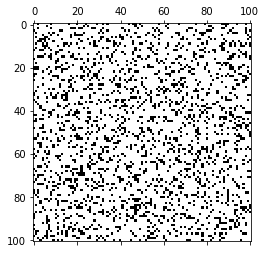

In [12]:
maze_size = 101
agent_grid_world = np.full((maze_size, maze_size),3)
agent_grid_world = np.asmatrix(agent_grid_world)
full_grid_world = populateMatrix(maze_size, 0.2)
plt.spy(full_grid_world)

In [14]:
def next_move(current_node, predictions, full_grid_world, visited_list, maze_size, trajectory, flag, agent_grid_world):
    """
    Based on prediction made by the Neural Network, this function decides the next move of the agent
    current_node: The node that the agent is currently present in
    predictions: The output given by Neural Network
    full_grid_world: The actual maze/gridworld
    visited_list: list of nodes that have been visited by the agent
    maze_size: Size of the gridworld
    trajectory: The path that agent took to reach the goal
    flag: status to check if the current node is blocked or not
    agent_grid_world: The agent-discovered portion of the full grid world
    """
    message = ''
    indices = zip(np.where(predictions[0] == predictions[0].max()))

    for row in indices:
        if row[0][0] == 0:
            message = 'up'
            next_node = (current_node[0] - 1, current_node[1])
        elif row[0][0] == 1:
            message = 'down'
            next_node = (current_node[0] + 1, current_node[1])
        elif row[0][0] == 2:
            message = 'left'
            next_node = (current_node[0], current_node[1] - 1)
        elif row[0][0] == 3:
            message = 'right'
            next_node = (current_node[0], current_node[1] + 1)
    
    try:
        if agent_grid_world[next_node] == 2 or next_node[0] > maze_size-1 or next_node[1] > maze_size-1 or next_node in visited_list:
            children = get_children(current_node[0], current_node[1], maze_size, visited_list)
            i = random.randint(0,len(children)-1)
            if (next_node[0], next_node[1]) == (current_node[0] - 1, current_node[1]):
                message = 'up'
            elif (next_node[0], next_node[1]) == (current_node[0] + 1, current_node[1]):
                message = 'down'
            elif (next_node[0], next_node[1]) == (current_node[0] - 1, current_node[1]):
                message = 'left'
            elif (next_node[0], next_node[1]) == (current_node[0] + 1, current_node[1]):
                message = 'right'

            return children[i], message
    except Exception as err:
        children = get_children(current_node[0], current_node[1], maze_size, visited_list)
        i = random.randint(0,len(children)-1)
    
        if (children[0], children[1]) == (current_node[0] - 1, current_node[1]):
                message = 'up'
        elif (children[0], children[1]) == (current_node[0] + 1, current_node[1]):
            message = 'down'
        elif (children[0], children[1]) == (current_node[0] - 1, current_node[1]):
            message = 'left'
        elif (children[0], children[1]) == (current_node[0] + 1, current_node[1]):
            message = 'right'

#         print('next_node out changed from:', next_node, 'to ', children[i])
        return children[i], message
    
#     print('next_node out::',next_node)
    return next_node, message

In [15]:
def get_neighbors(row, col, n):
    """
    Returns the immediate neighbors of the node (row, col)
    n: Maze size
    """
    dir = [[-1, -1], [-1, 0],[-1, 1], [0, -1], [0, 0],  [0, 1], [1, -1], [1, 0], [1, 1]]
    friend = []
    count = 0
    for x, y in dir:
        row_new = row + x
        col_new = col + y
        if (row_new>=0 and row_new<=(n-1)) and (col_new>=0 and col_new<=(n-1)):
            count += 1
            friend.append((row_new, col_new))
    return count, friend

In [16]:
def get_window(current_node, agent_grid_world, full_grid_world):
    """
    Since we use the local information, this function returns the local 3x3 grid surrounding the agent.
    current_node: The node that the agent is currently present in
    agent_grid_world: The agent-discovered portion of the full grid world
    full_grid_world: The actual maze/gridworld
    """
    a = []
    b = []
    count, neighbors = get_neighbors(current_node[0],current_node[1], maze_size)

    if len(neighbors) == 4:
        if current_node == (0,0):
            count, neighbors = get_neighbors(1,1, maze_size)
        elif current_node == (0,maze_size-1):
            count, neighbors = get_neighbors(1,maze_size-2, maze_size)
        elif current_node == (maze_size-1,0):
            count, neighbors = get_neighbors(maze_size-2, 1, maze_size)
        elif current_node == (maze_size-1,maze_size-1):
            count, neighbors = get_neighbors(maze_size-2,maze_size-2, maze_size)
    elif len(neighbors) == 6:
        if current_node[0] == 0:
            count, neighbors = get_neighbors(current_node[0] + 1,current_node[1], maze_size)
        elif current_node[0] == maze_size-1:
            count, neighbors = get_neighbors(current_node[0] - 1,current_node[1], maze_size)
        elif current_node[1] == 0:
            count, neighbors = get_neighbors(current_node[0],current_node[1] + 1, maze_size)
        elif current_node[1] == maze_size-1:
            count, neighbors = get_neighbors(current_node[0],current_node[1] - 1, maze_size)
    for i in neighbors:
        a.append(agent_grid_world[i])
        b.append(full_grid_world[i])
    window = np.asarray(a).reshape(3,3)

    return window

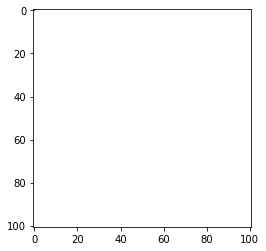

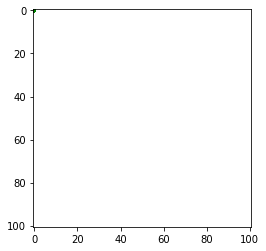

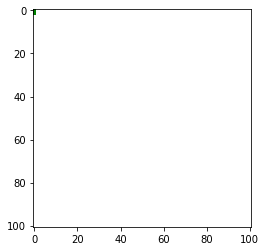

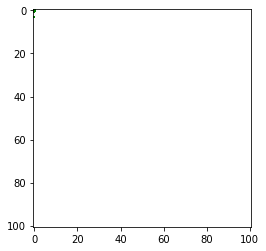

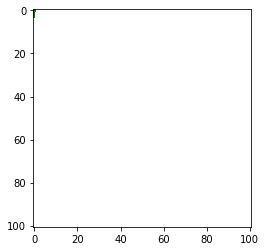

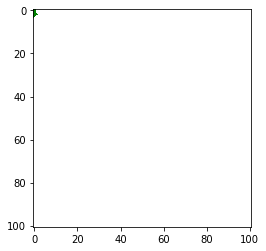

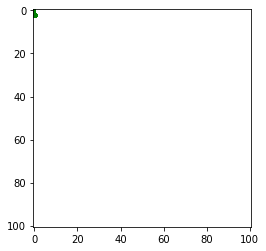

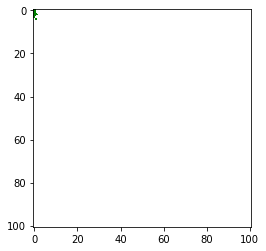

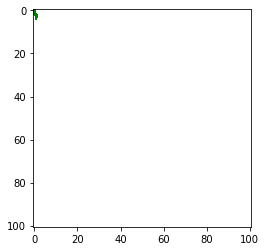

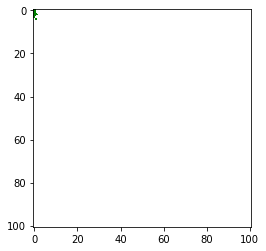

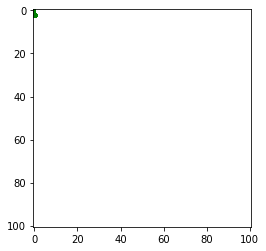

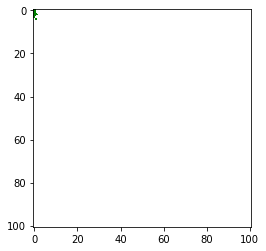

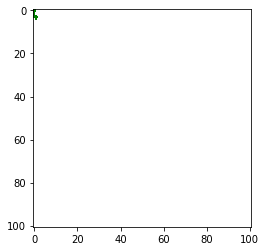

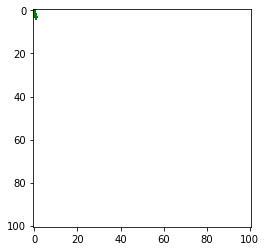

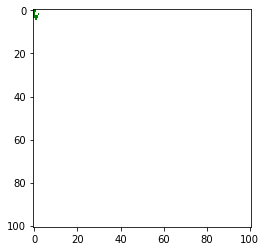

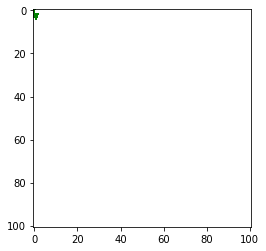

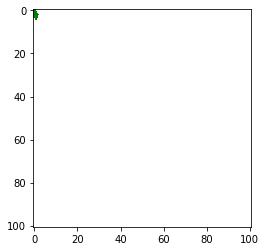

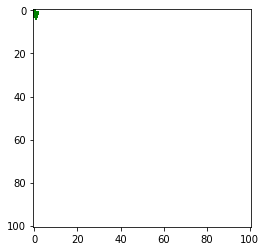

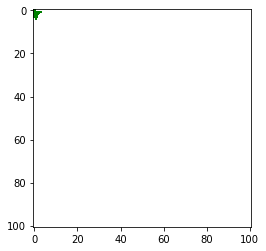

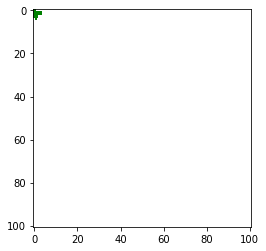

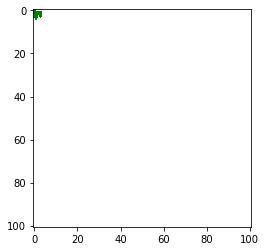

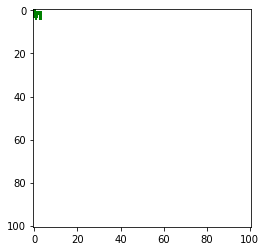

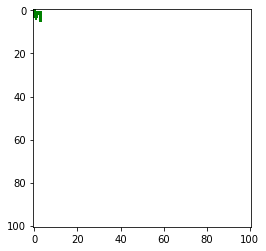

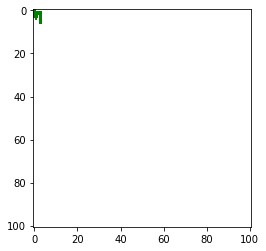

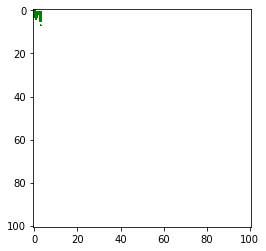

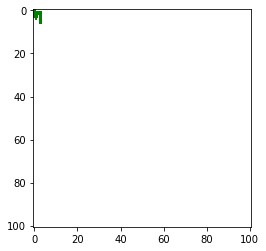

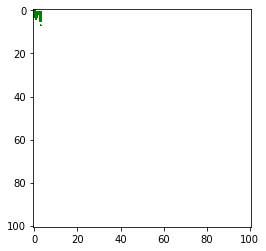

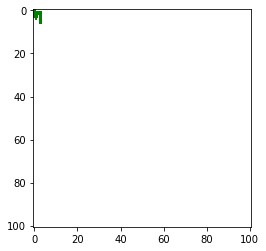

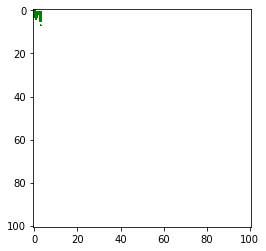

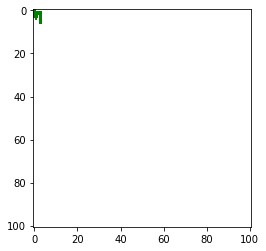

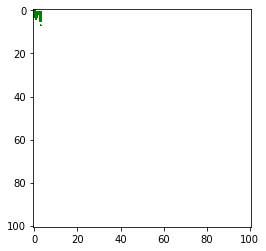

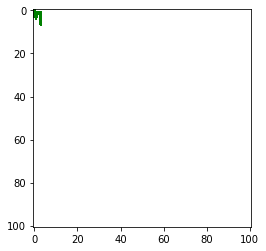

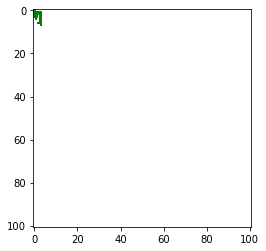

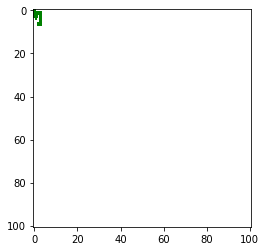

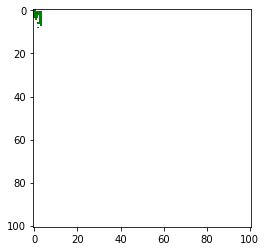

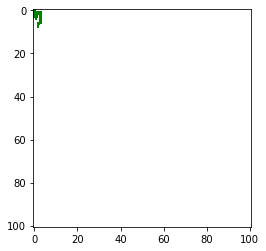

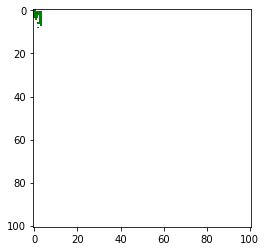

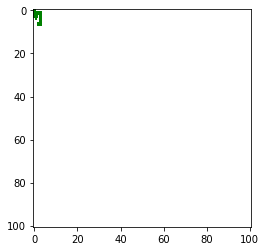

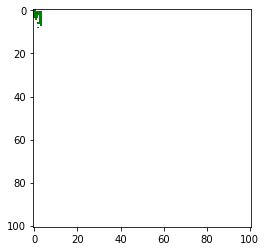

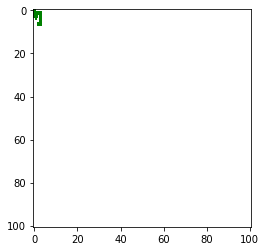

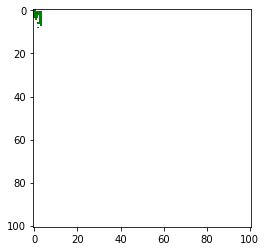

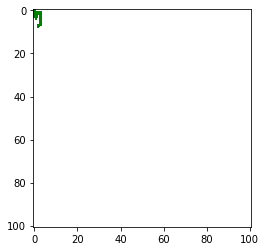

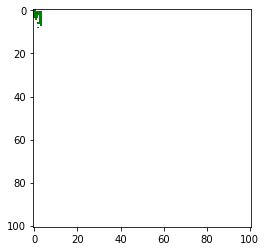

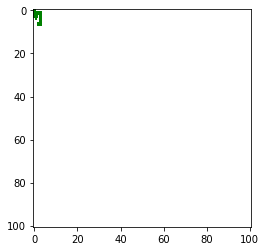

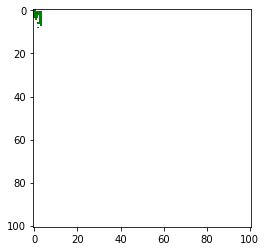

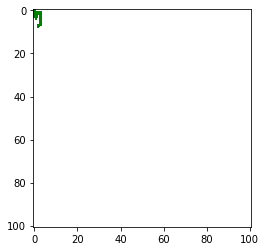

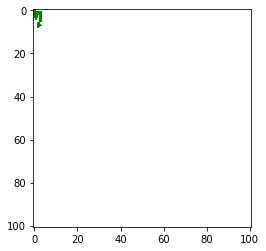

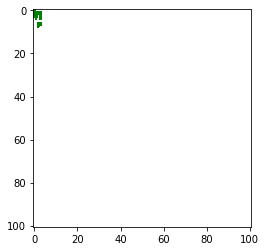

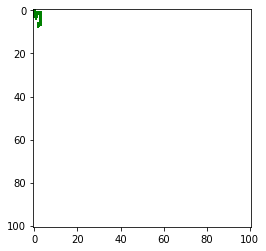

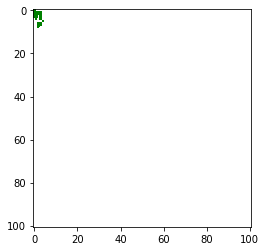

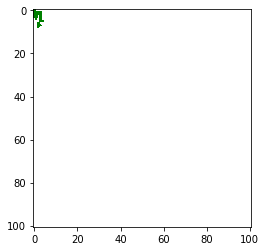

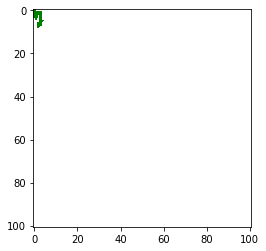

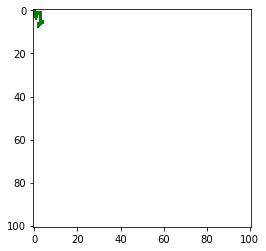

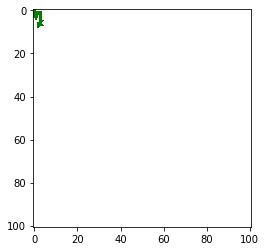

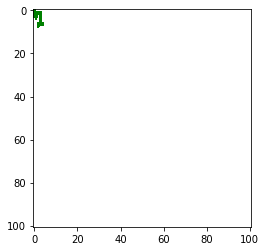

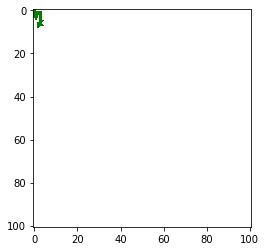

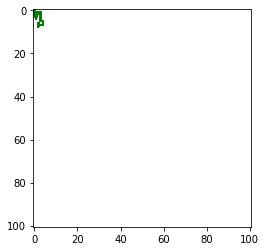

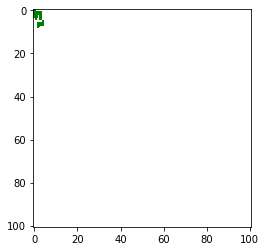

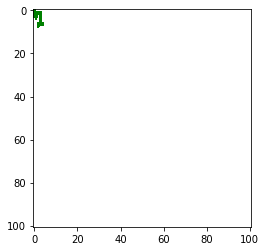

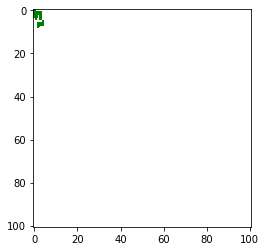

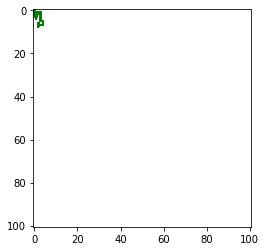

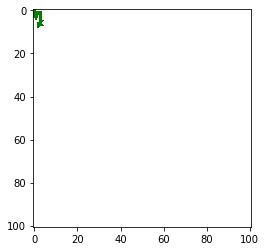

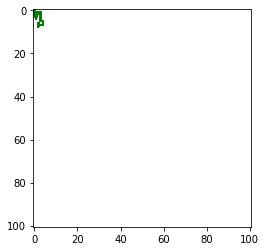

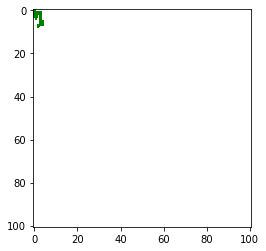

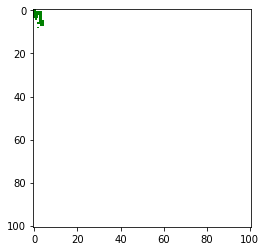

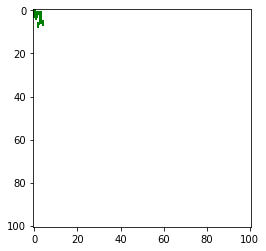

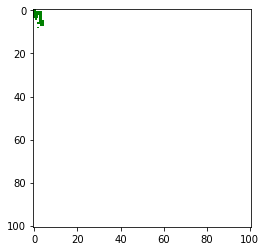

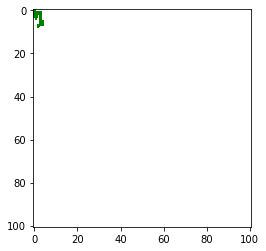

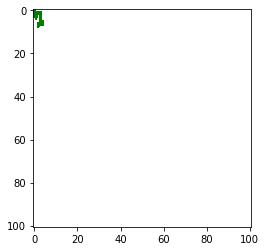

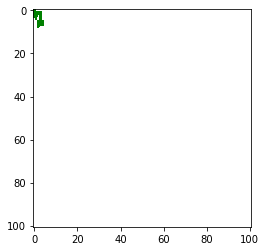

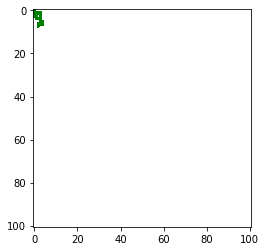

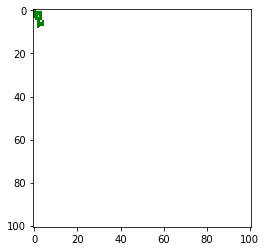

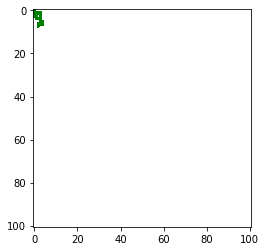

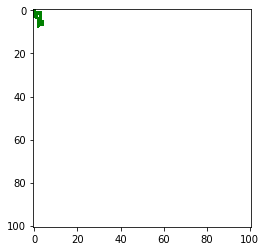

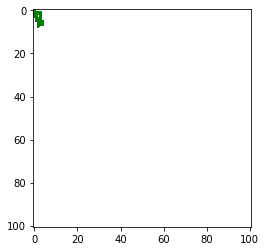

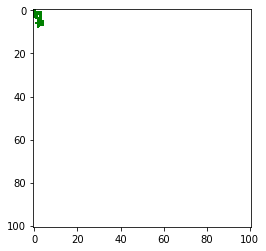

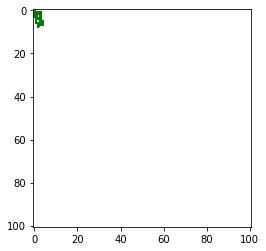

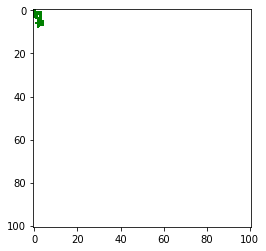

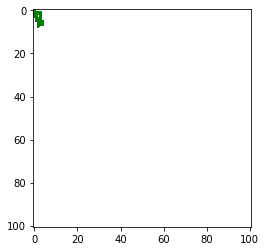

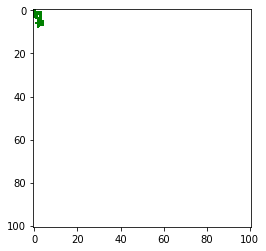

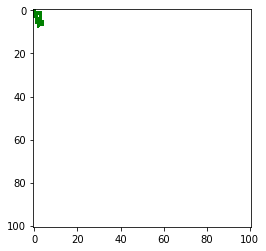

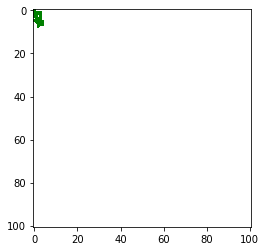

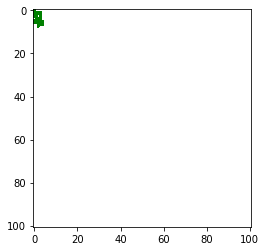

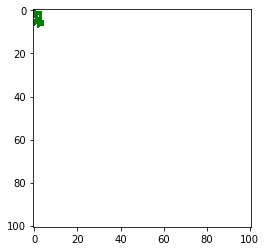

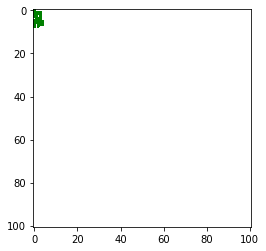

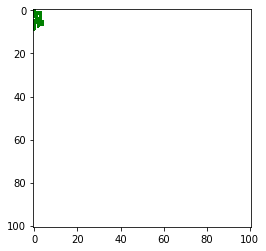

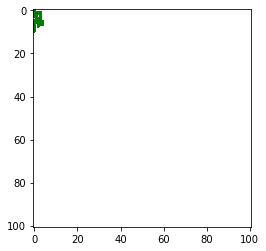

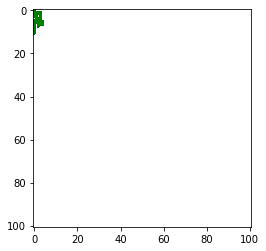

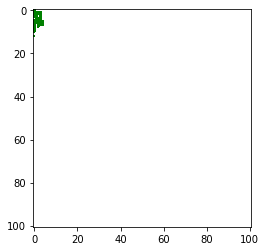

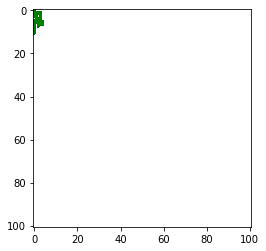

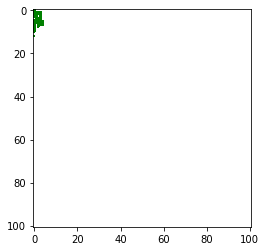

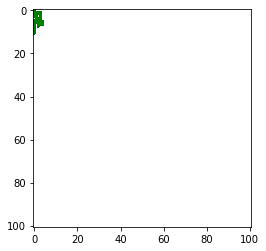

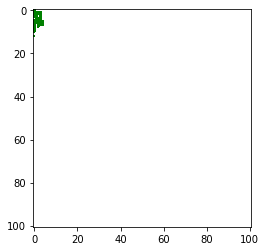

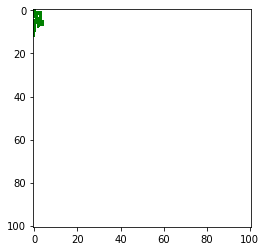

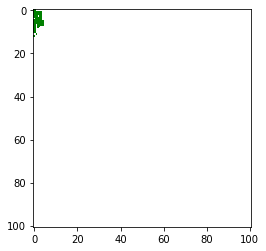

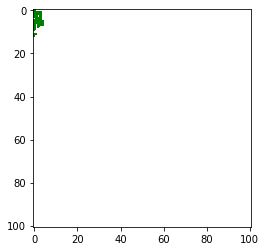

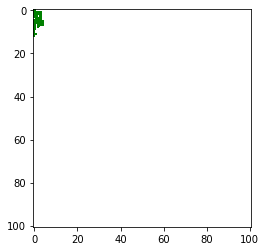

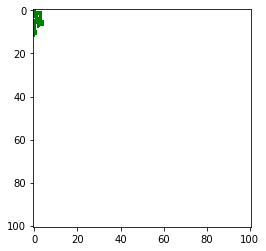

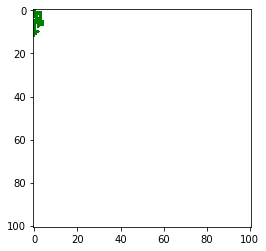

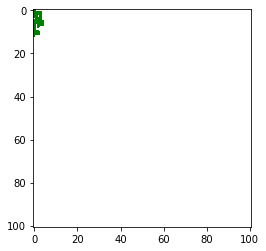

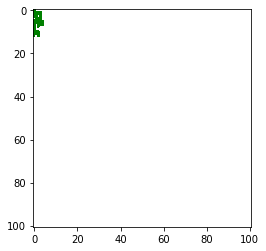

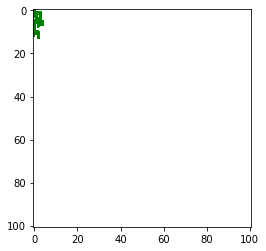

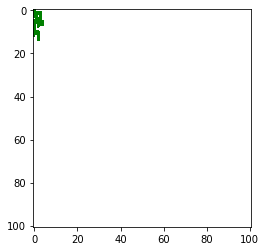

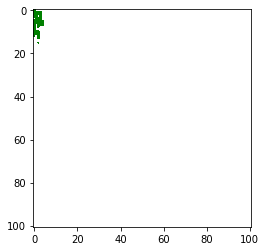

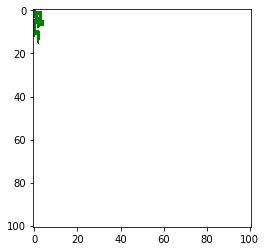

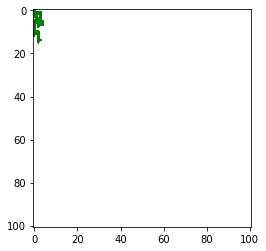

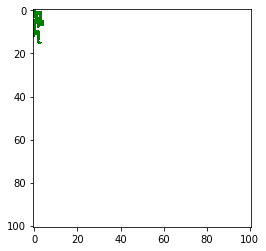

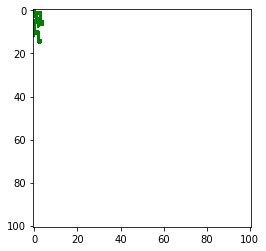

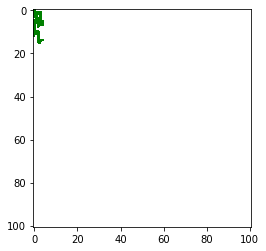

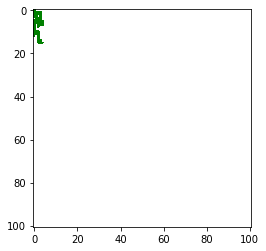

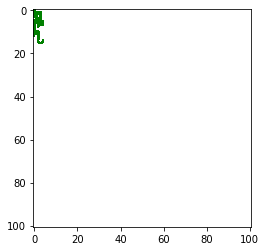

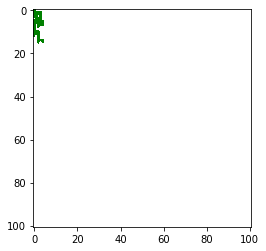

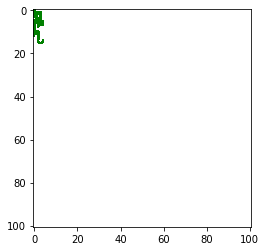

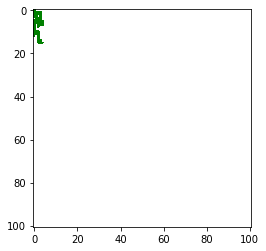

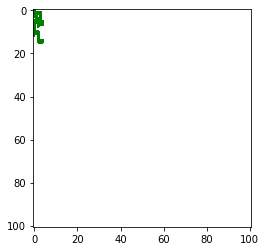

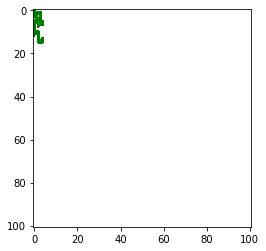

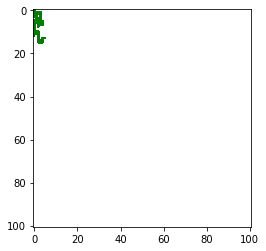

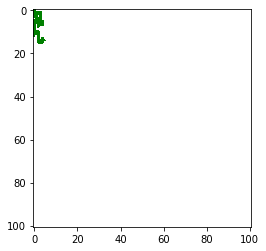

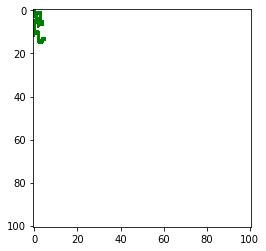

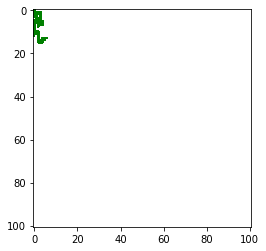

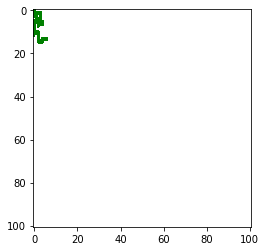

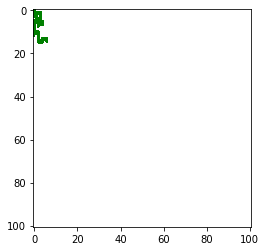

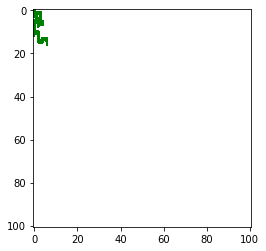

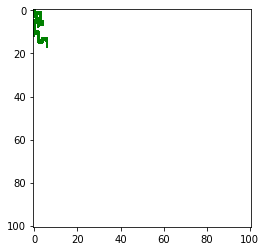

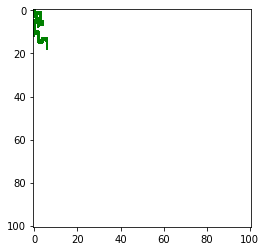

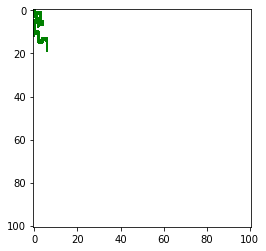

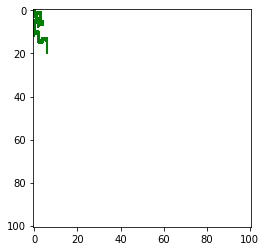

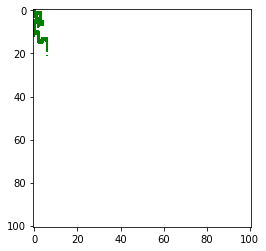

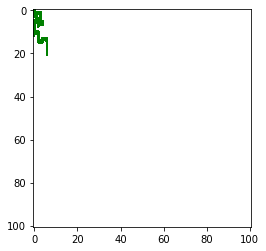

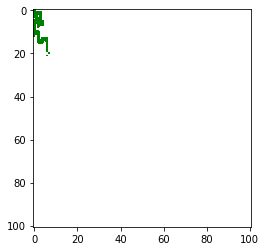

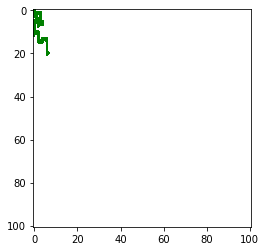

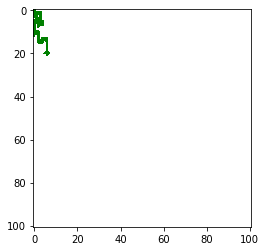

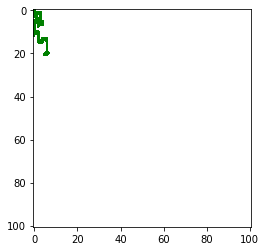

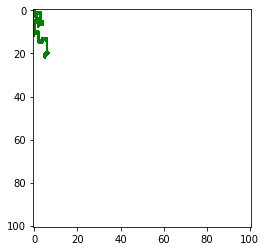

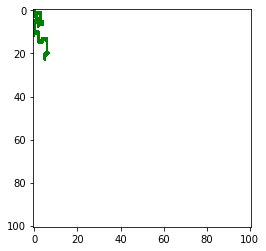

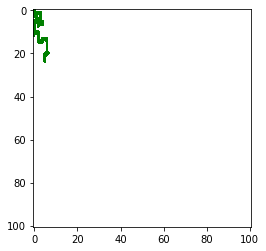

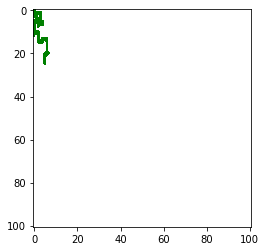

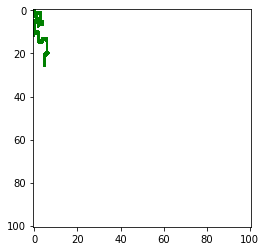

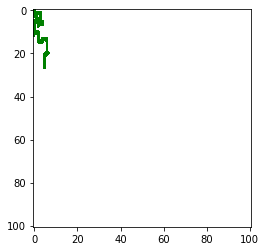

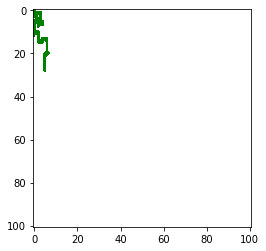

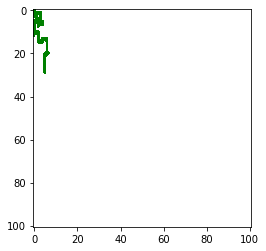

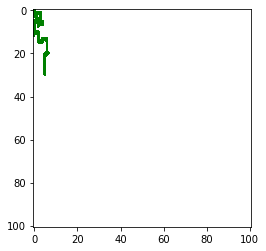

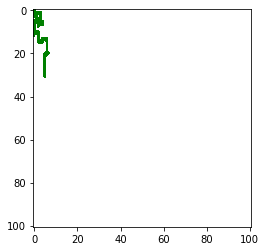

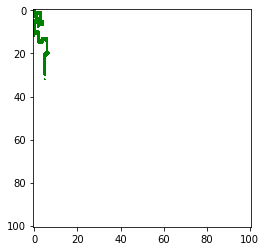

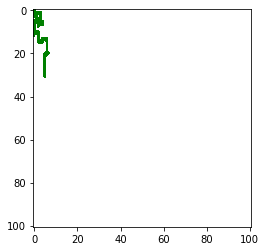

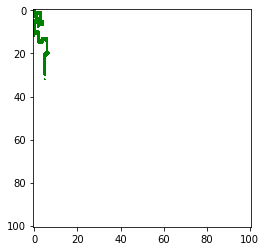

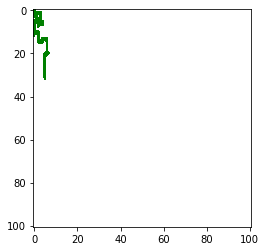

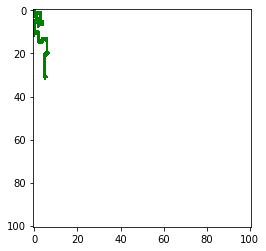

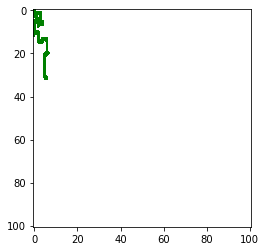

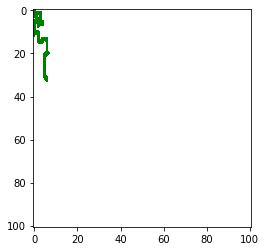

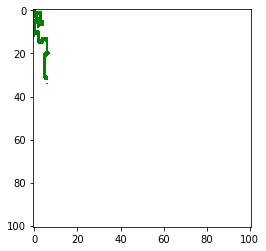

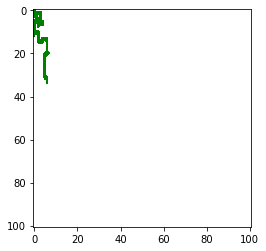

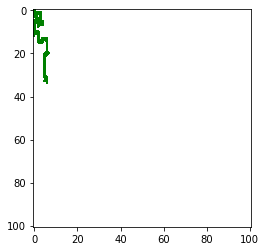

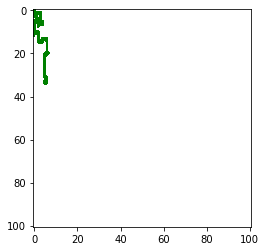

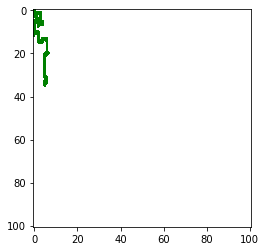

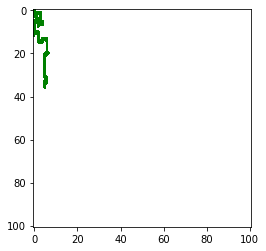

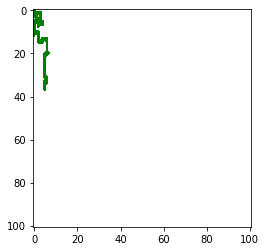

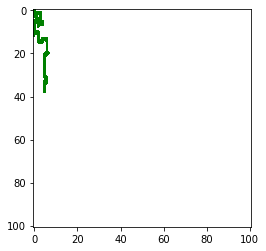

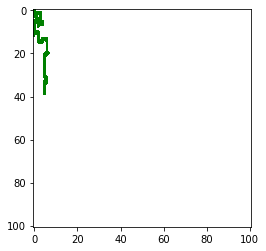

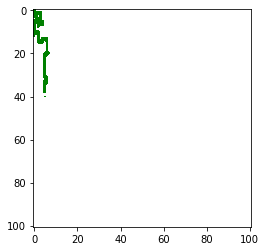

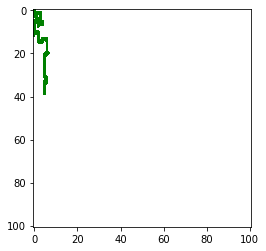

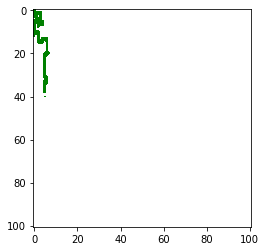

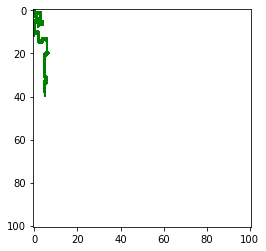

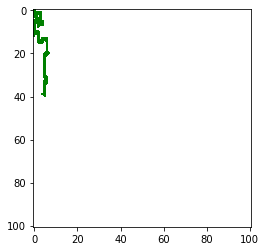

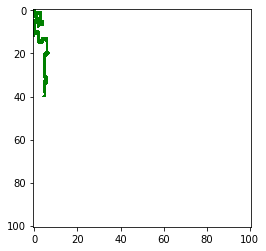

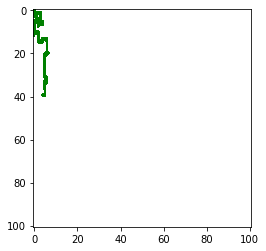

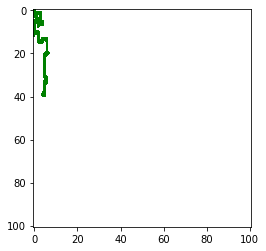

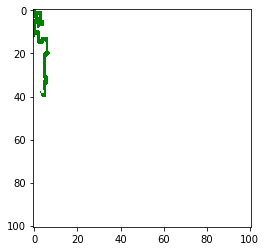

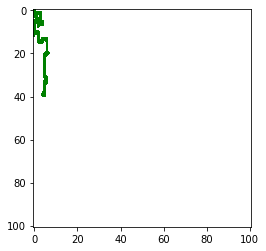

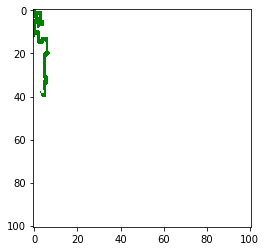

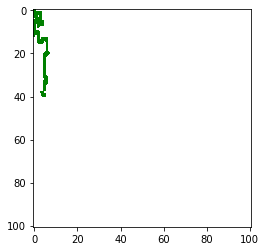

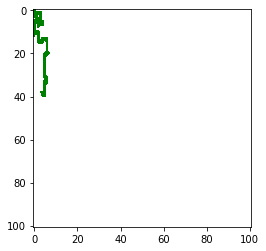

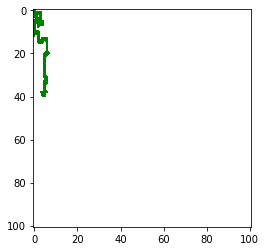

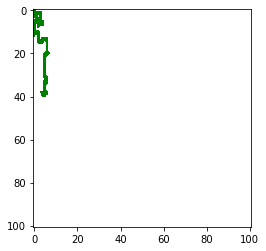

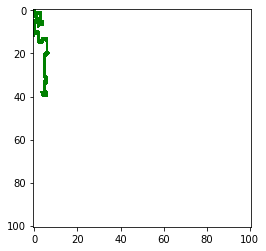

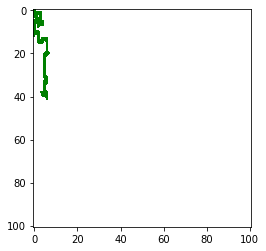

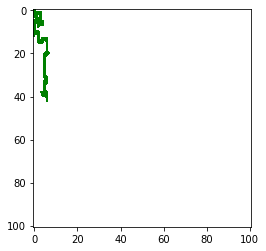

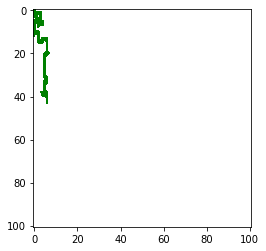

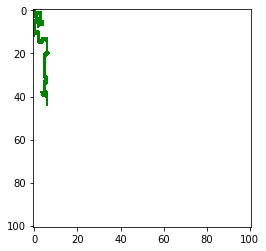

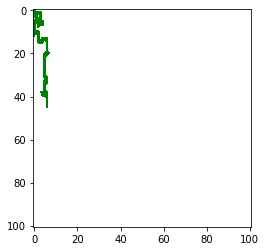

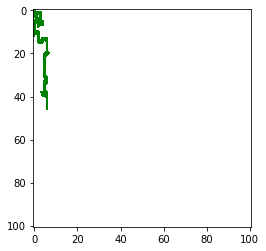

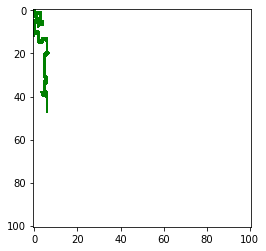

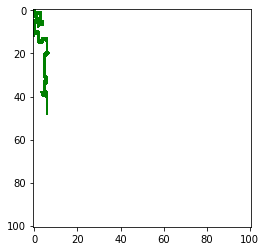

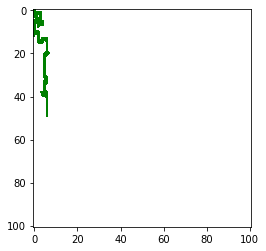

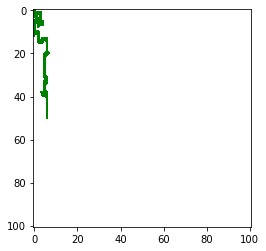

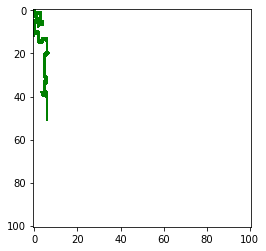

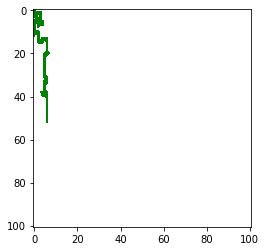

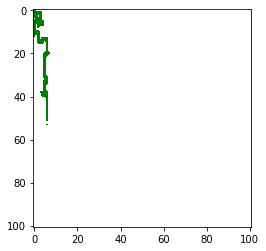

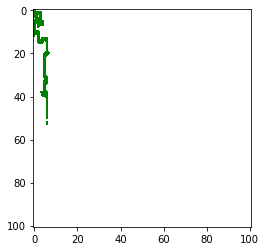

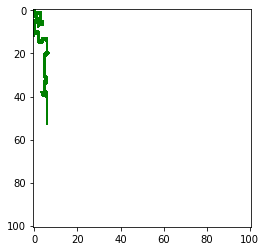

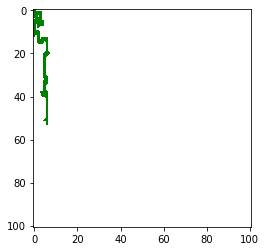

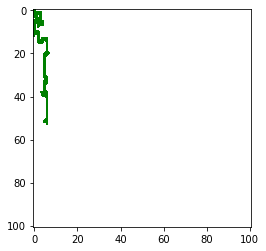

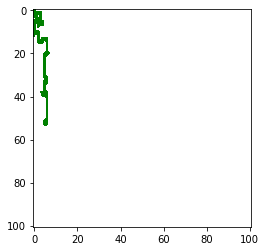

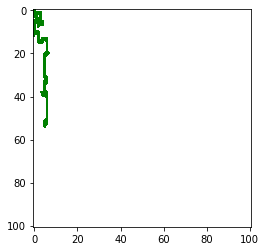

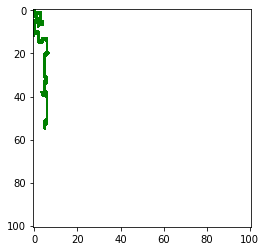

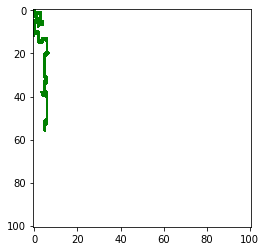

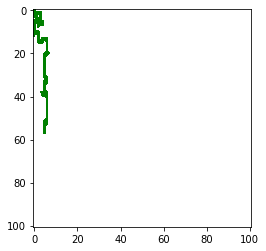

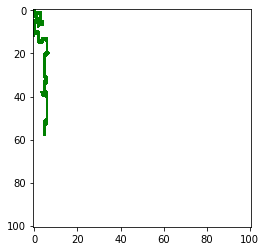

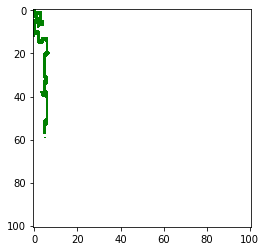

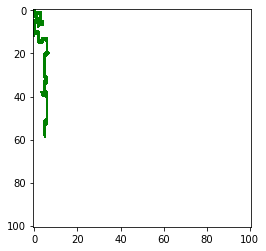

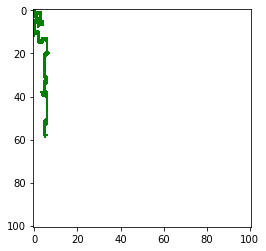

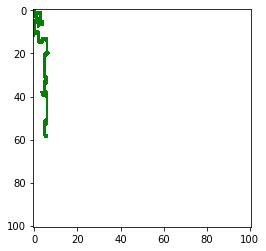

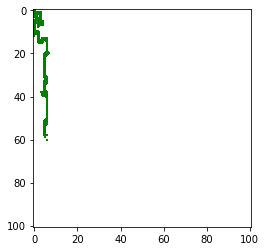

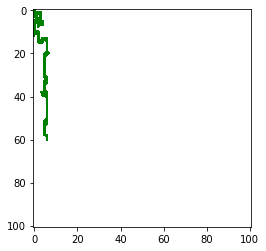

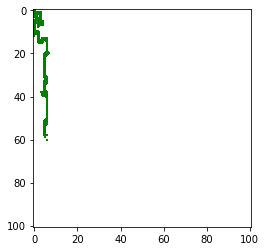

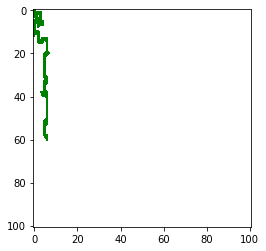

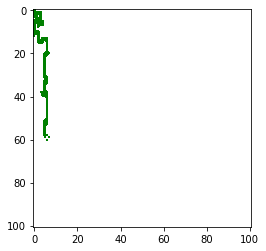

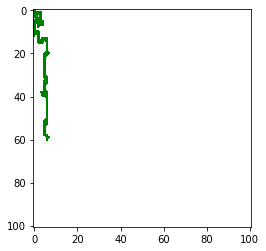

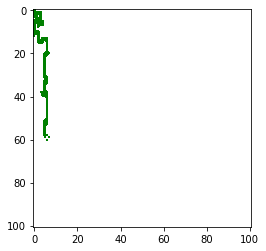

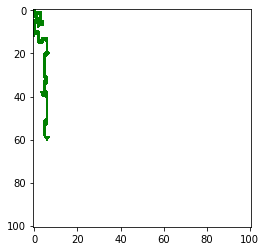

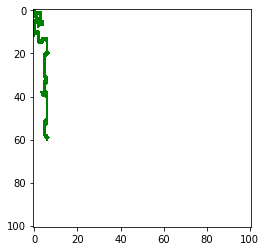

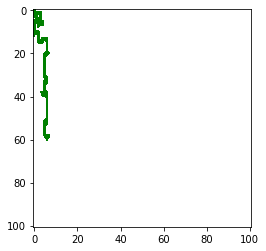

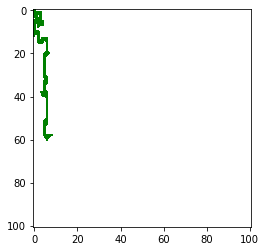

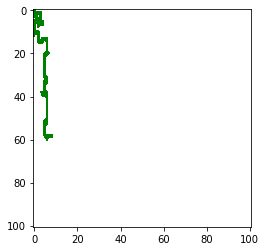

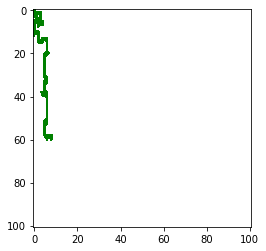

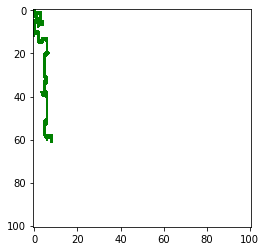

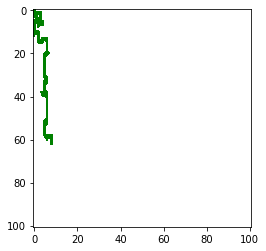

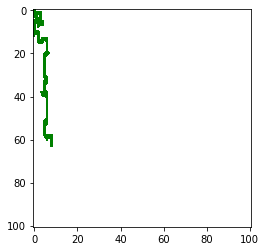

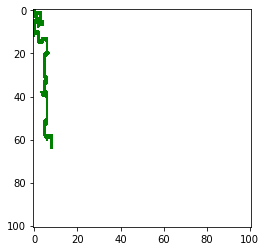

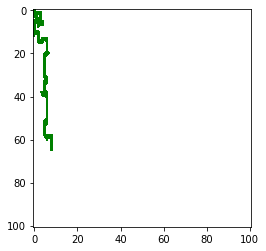

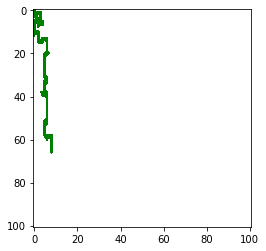

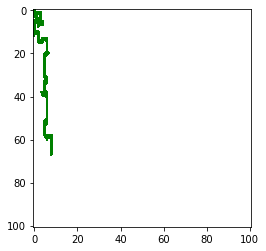

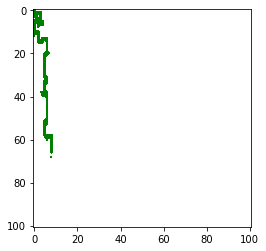

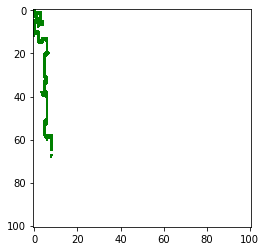

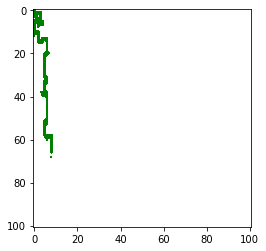

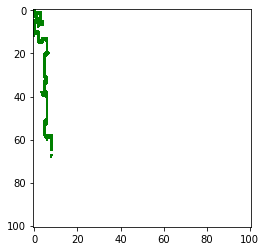

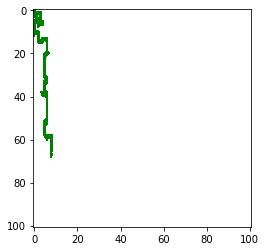

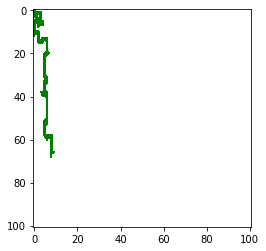

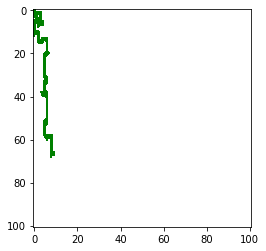

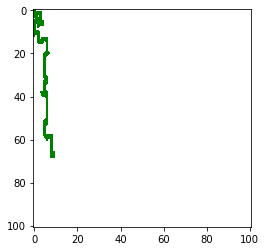

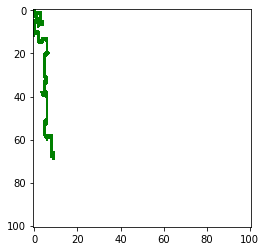

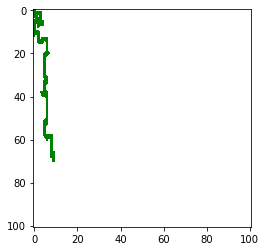

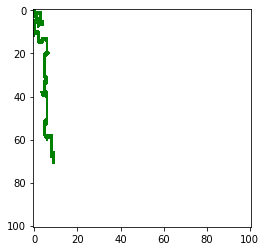

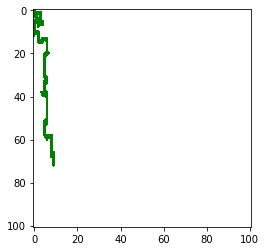

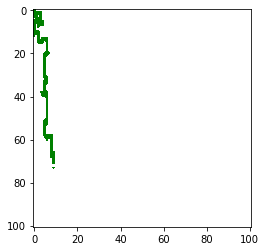

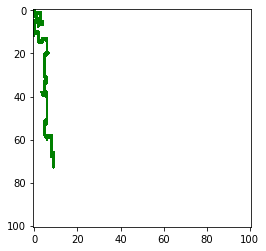

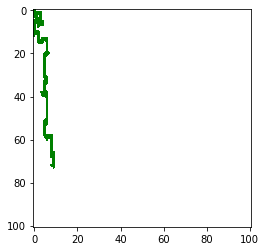

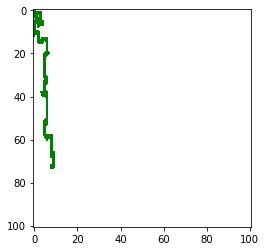

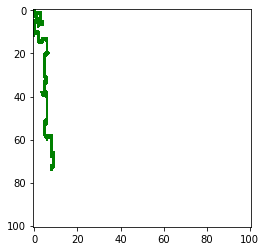

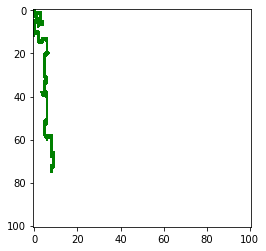

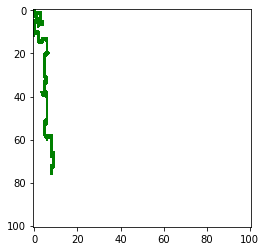

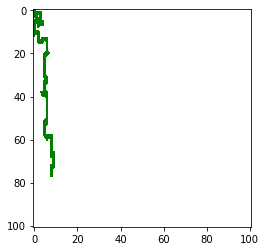

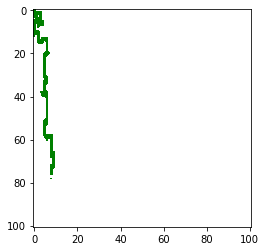

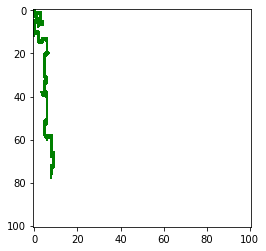

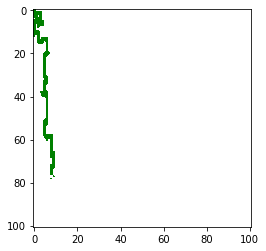

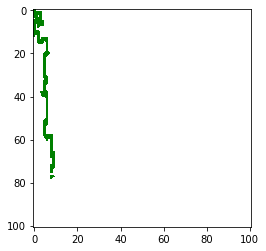

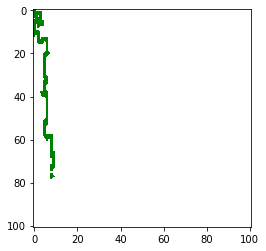

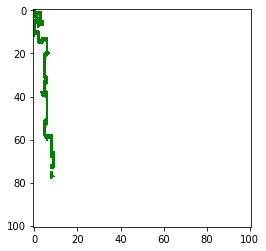

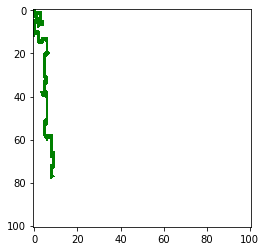

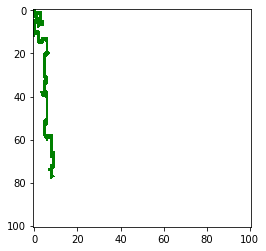

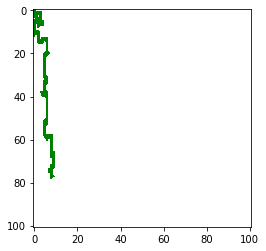

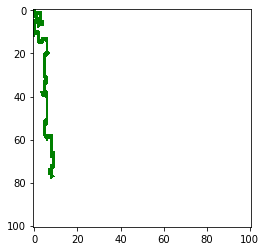

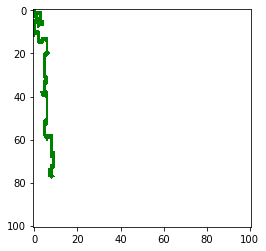

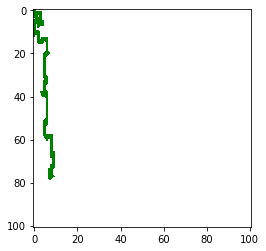

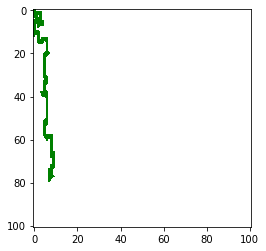

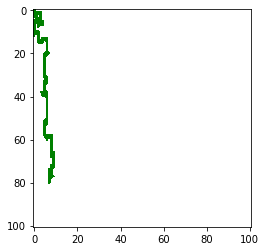

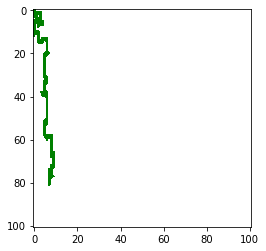

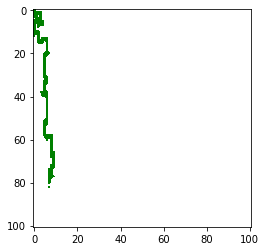

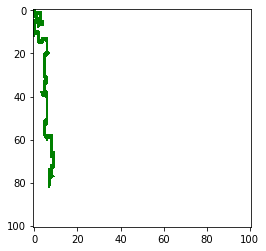

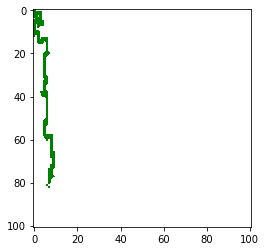

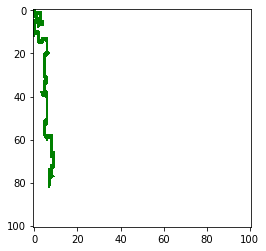

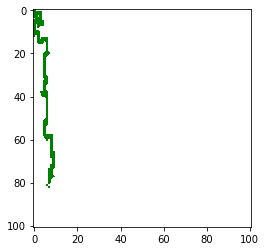

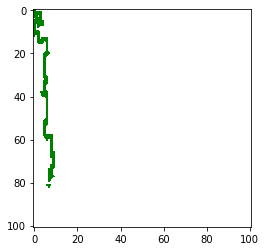

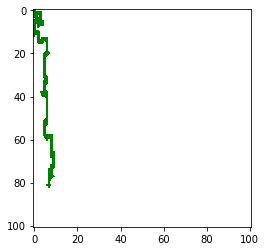

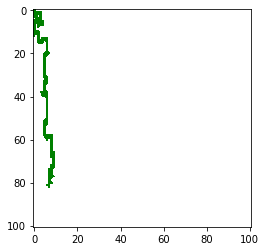

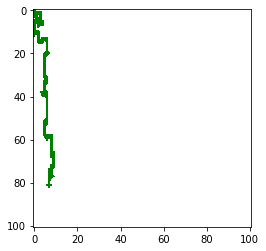

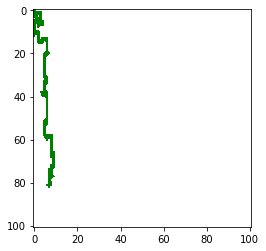

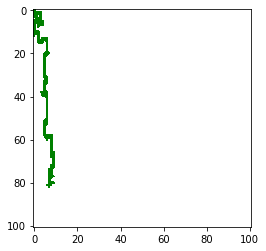

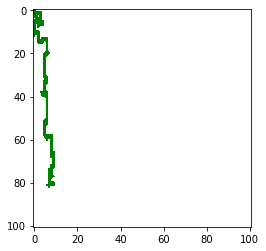

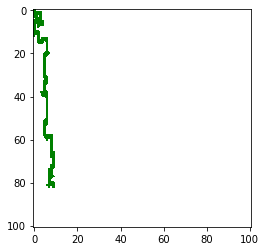

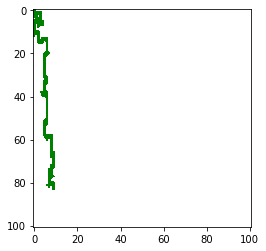

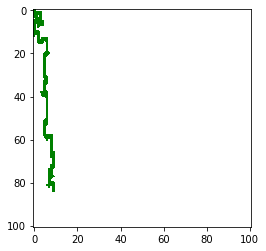

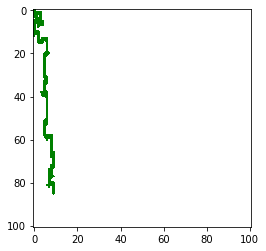

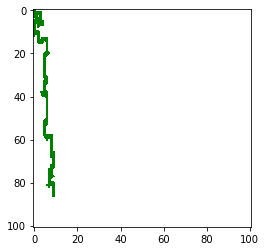

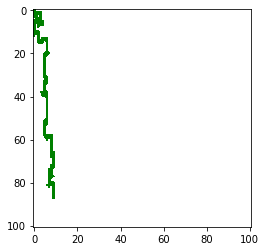

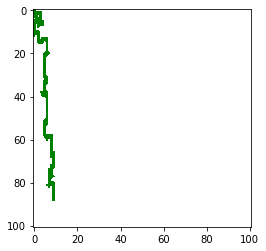

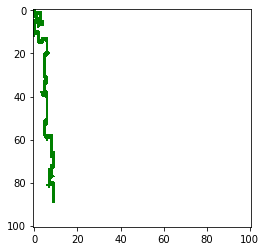

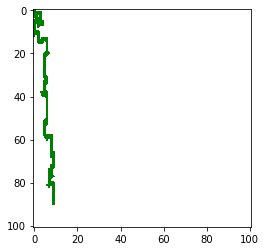

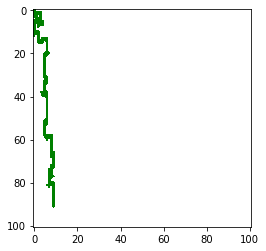

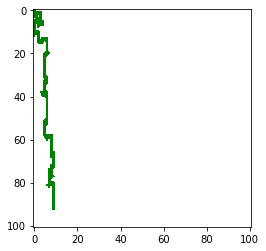

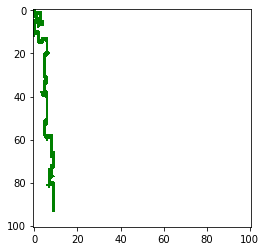

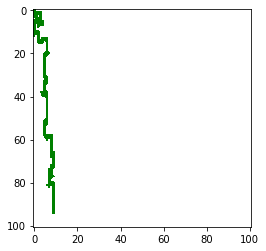

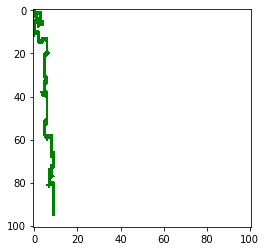

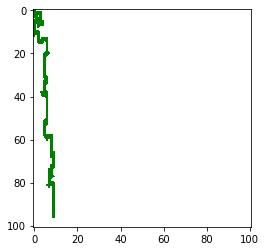

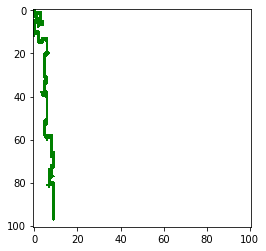

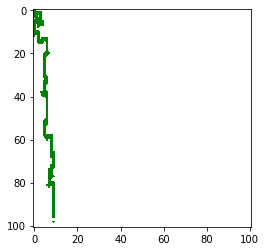

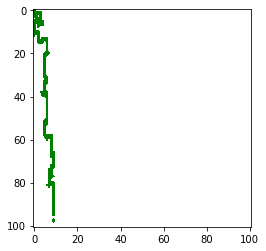

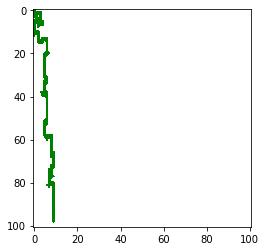

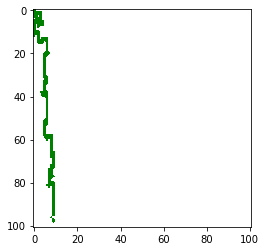

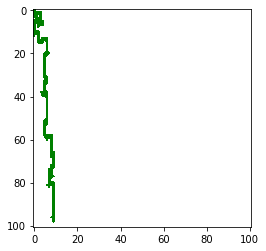

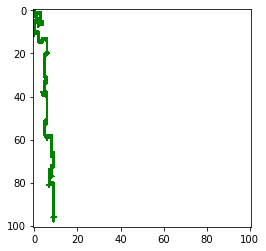

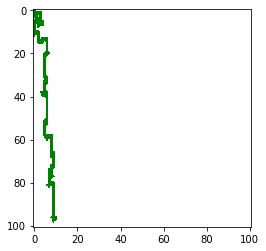

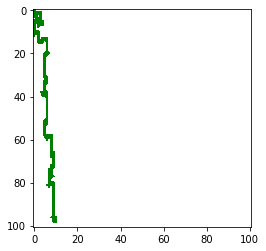

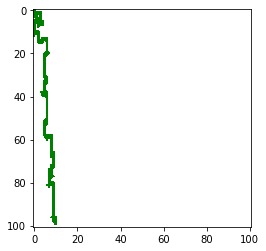

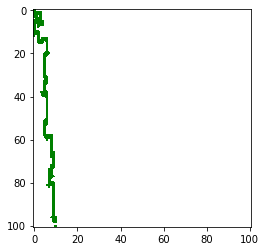

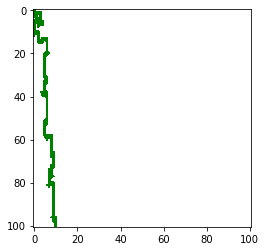

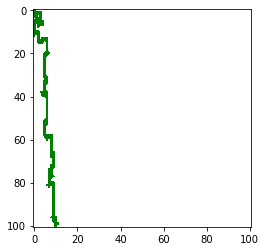

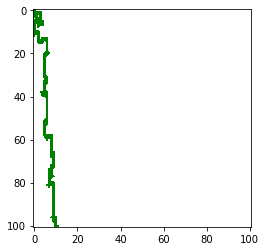

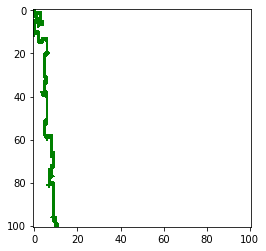

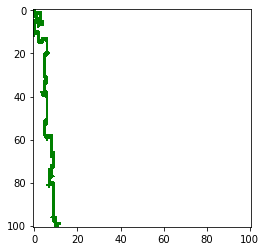

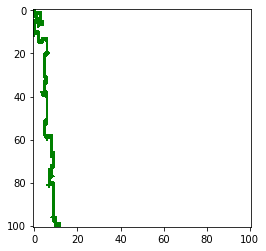

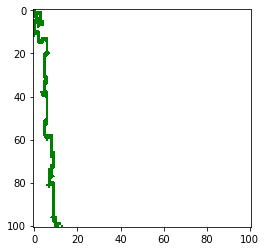

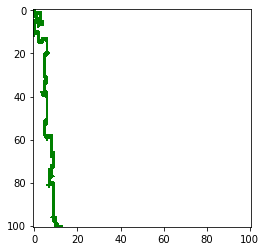

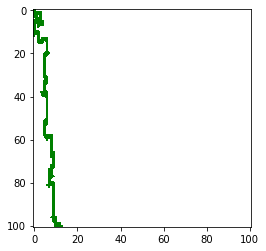

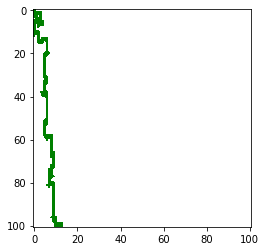

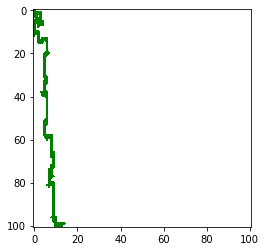

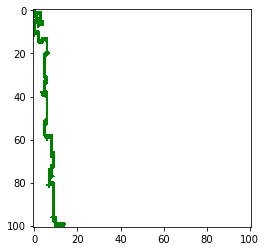

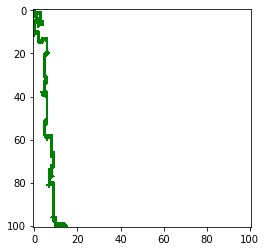

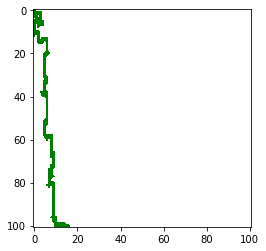

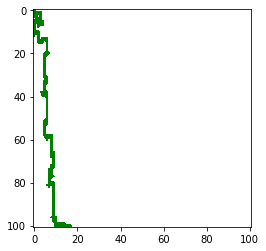

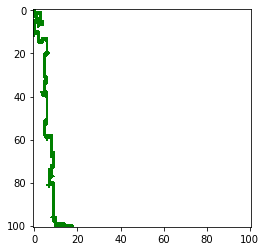

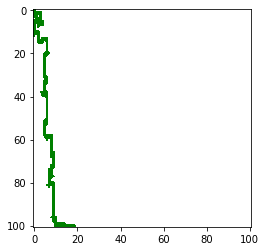

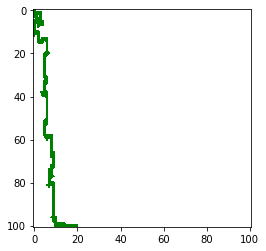

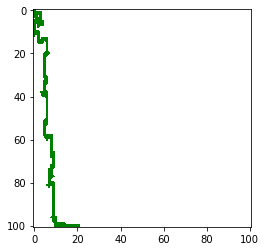

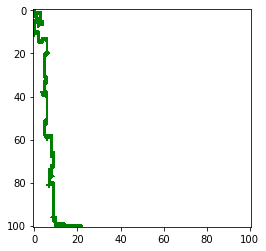

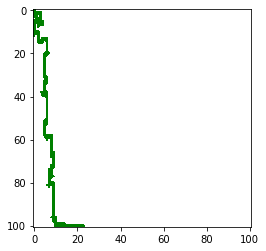

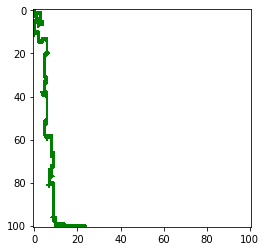

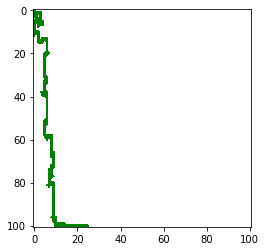

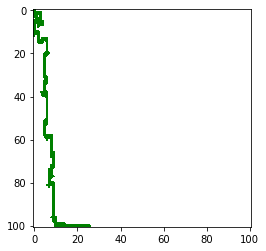

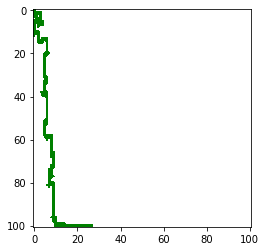

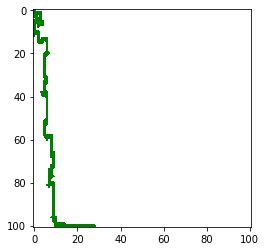

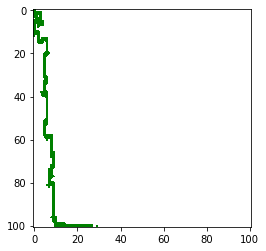

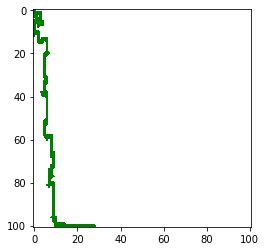

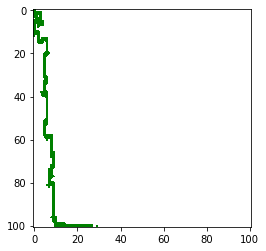

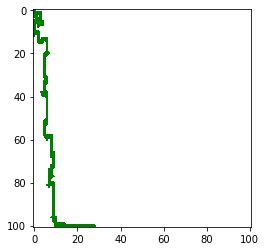

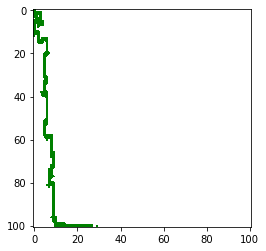

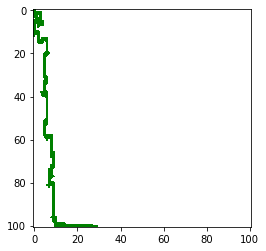

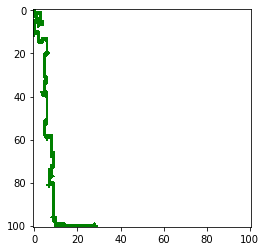

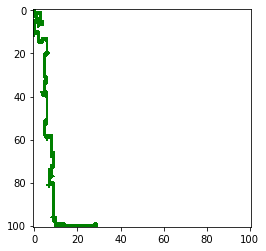

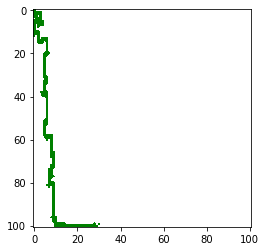

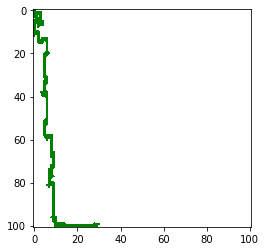

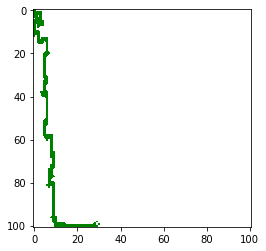

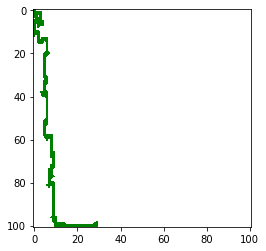

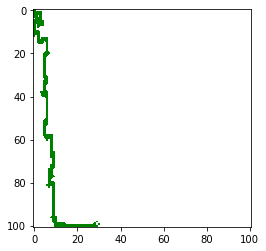

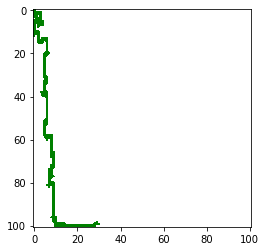

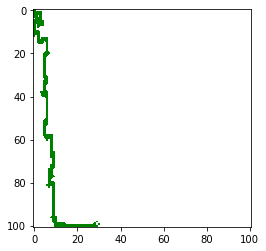

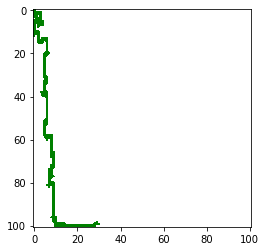

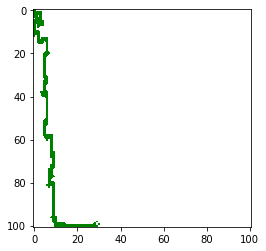

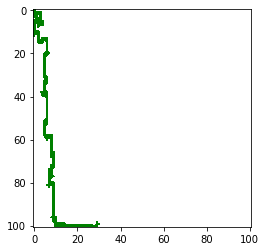

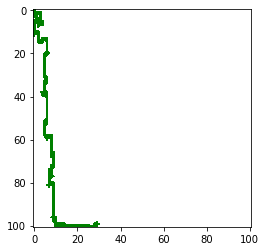

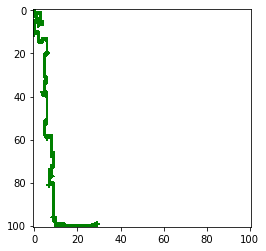

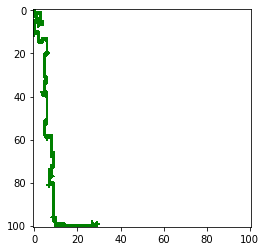

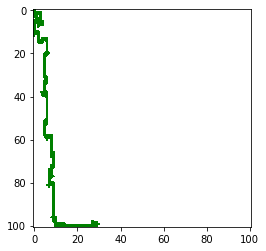

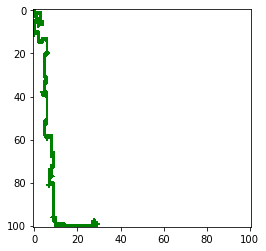

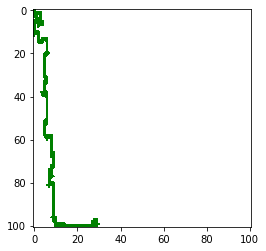

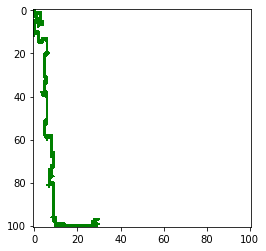

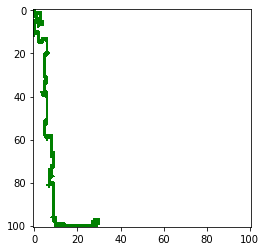

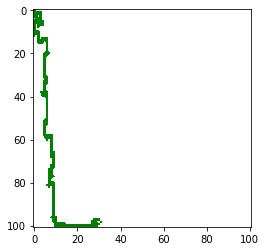

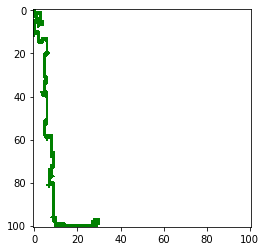

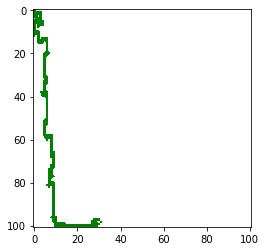

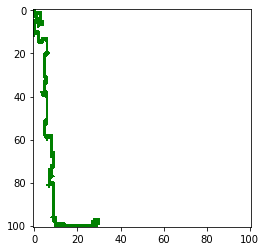

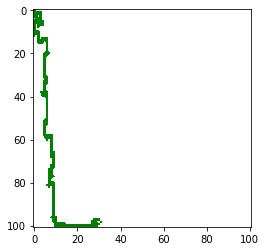

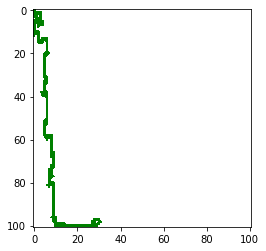

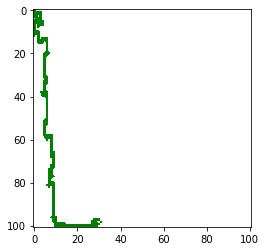

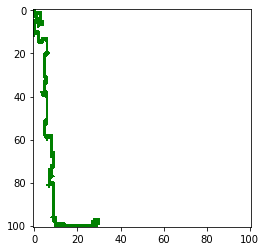

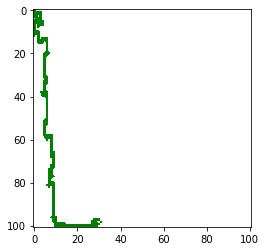

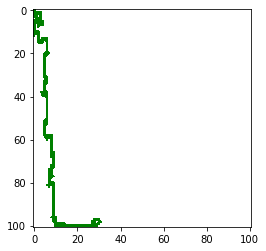

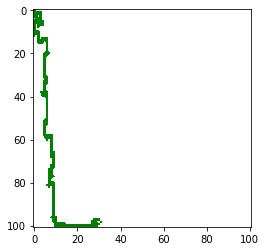

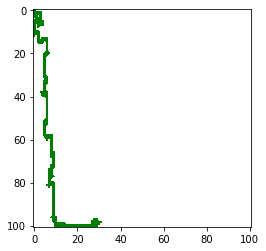

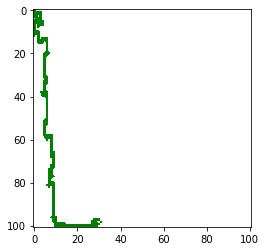

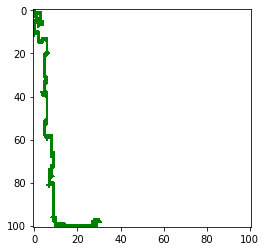

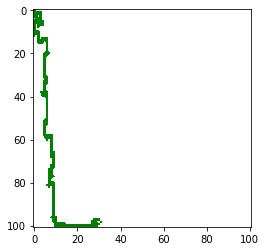

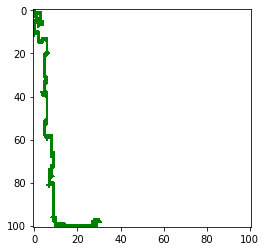

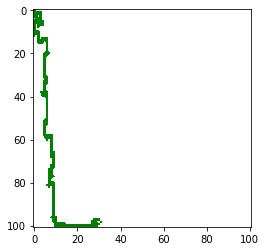

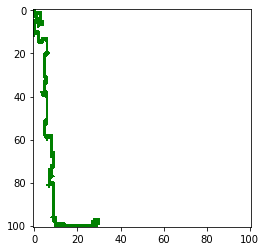

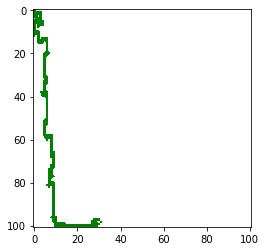

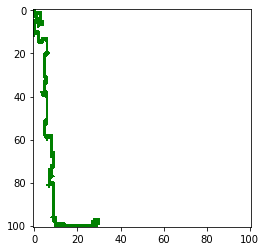

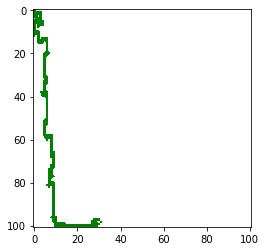

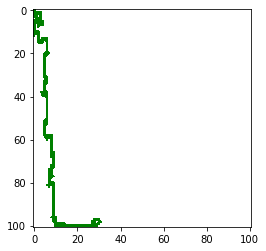

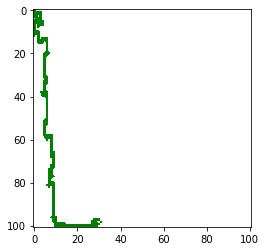

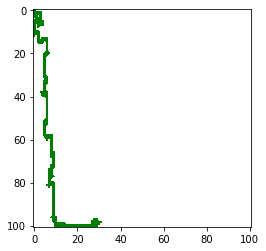

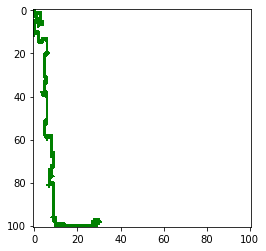

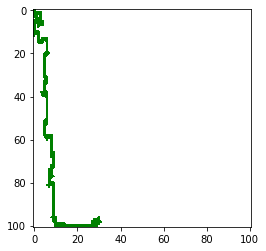

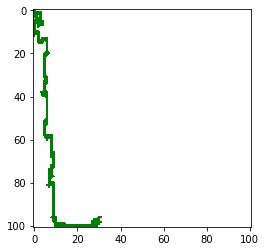

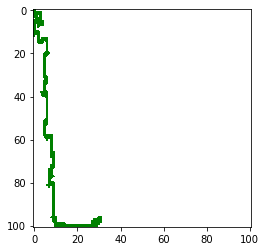

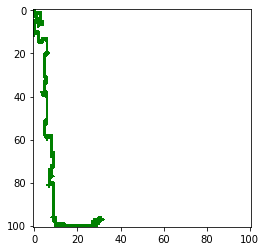

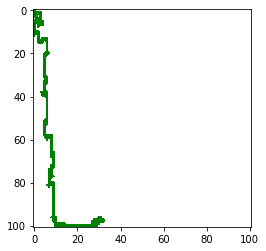

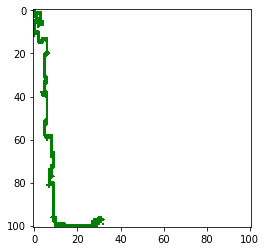

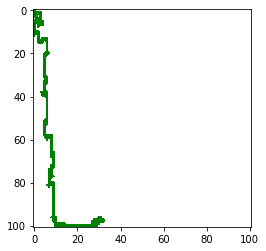

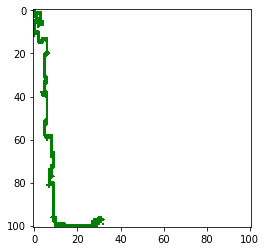

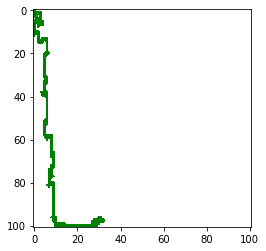

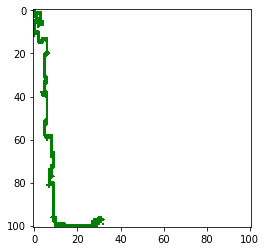

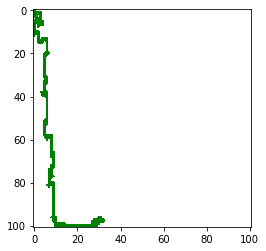

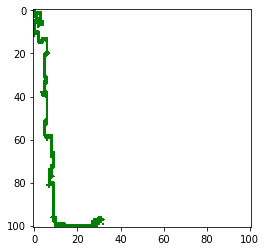

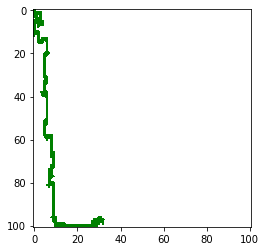

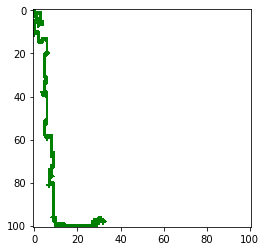

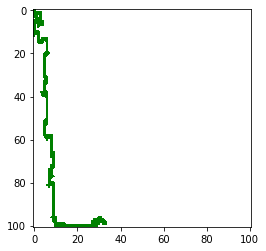

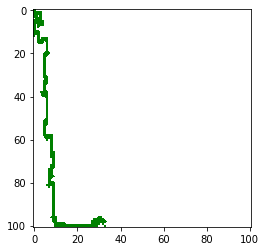

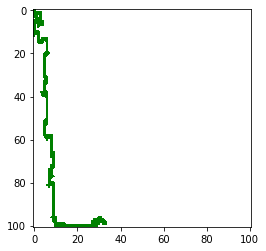

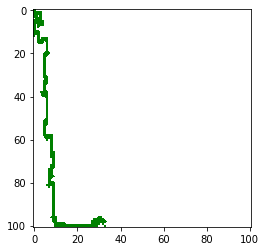

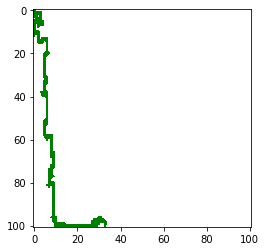

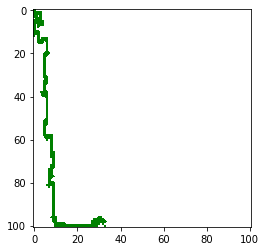

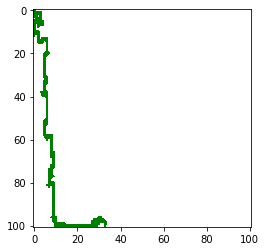

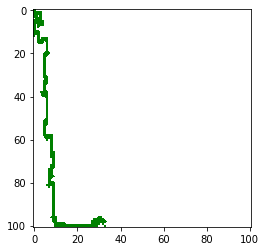

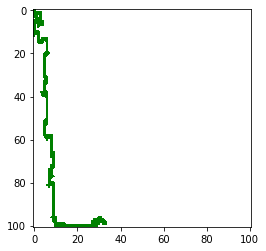

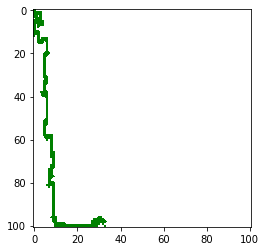

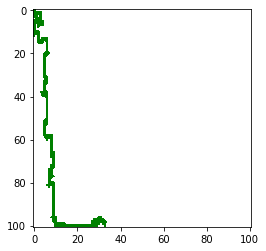

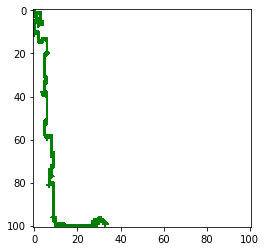

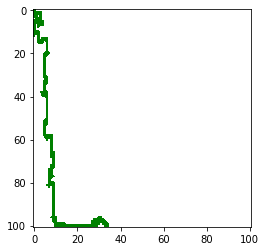

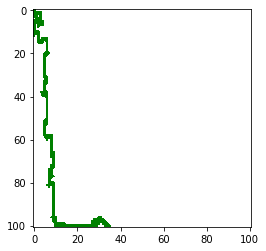

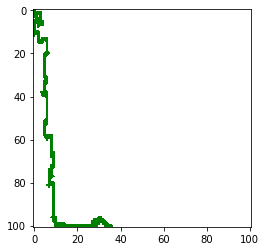

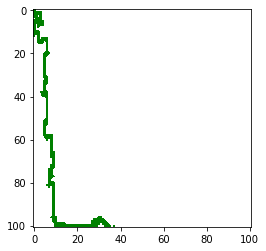

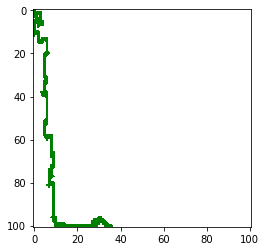

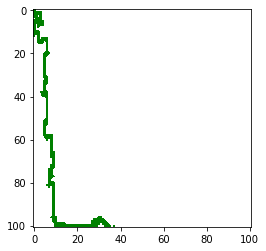

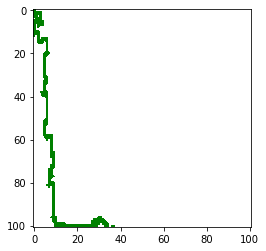

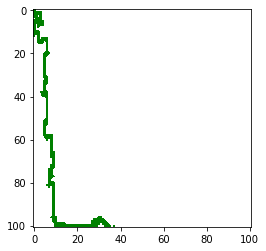

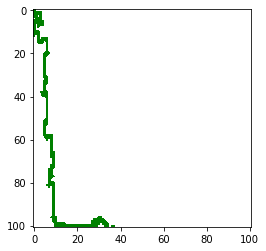

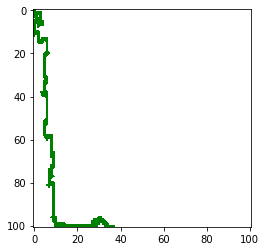

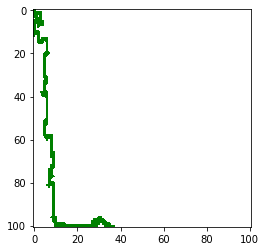

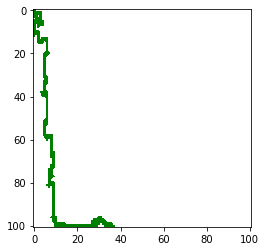

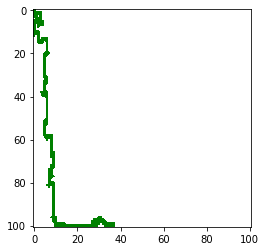

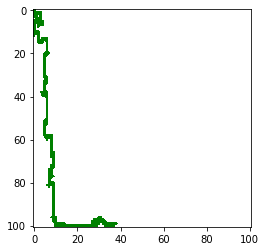

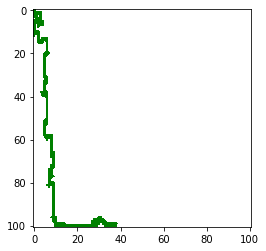

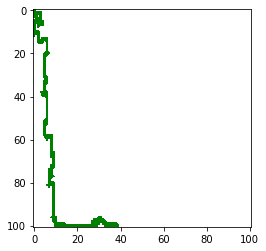

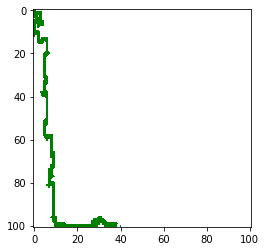

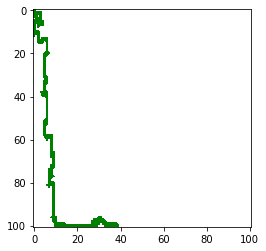

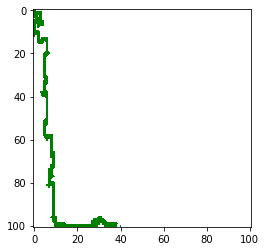

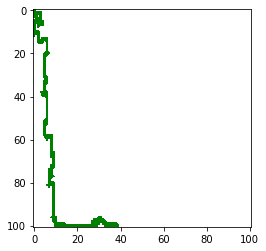

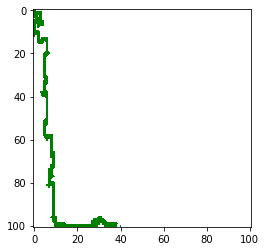

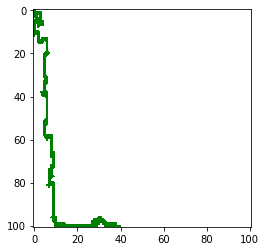

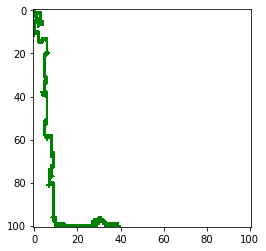

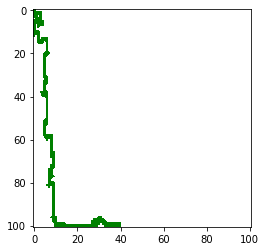

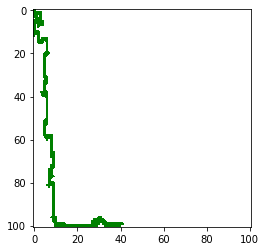

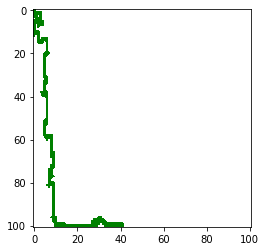

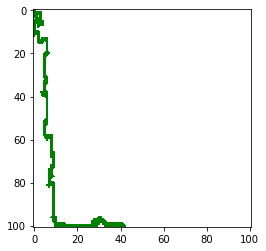

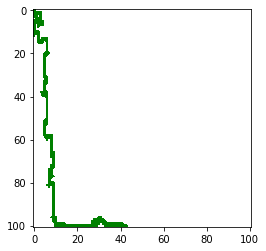

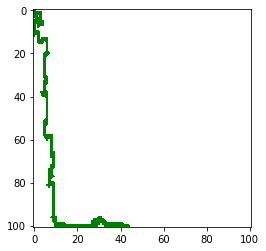

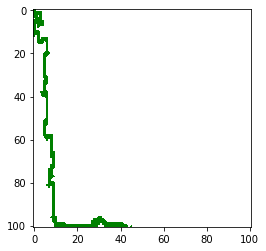

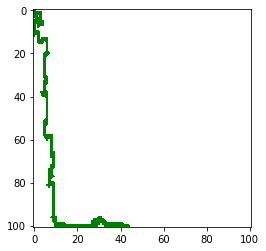

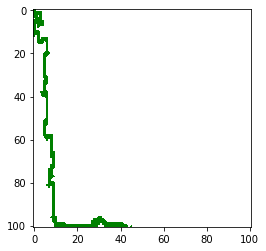

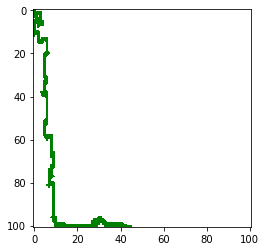

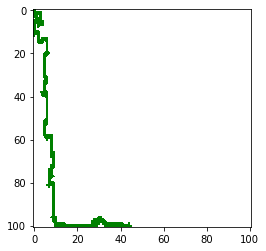

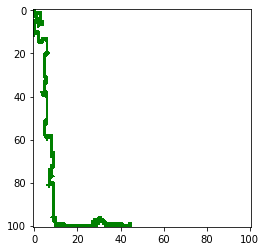

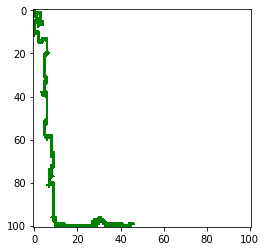

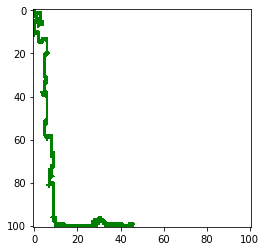

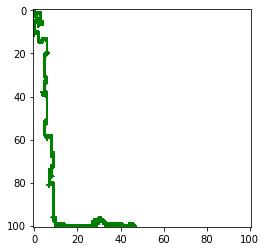

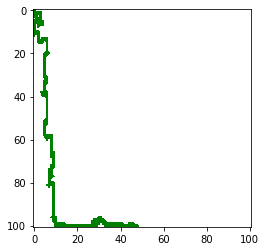

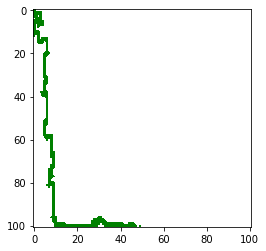

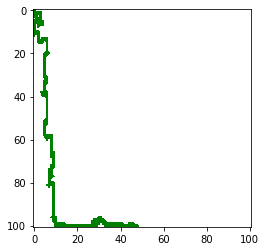

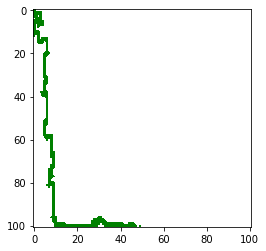

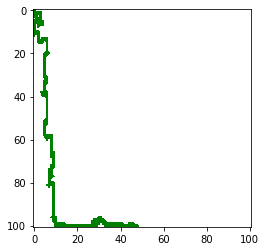

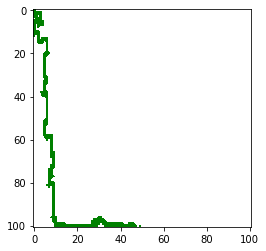

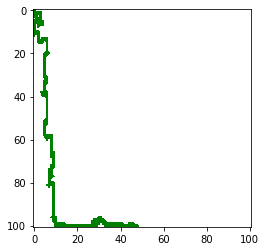

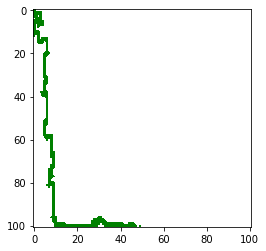

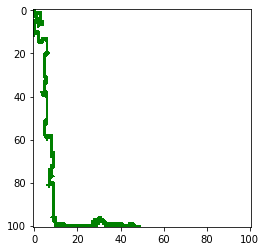

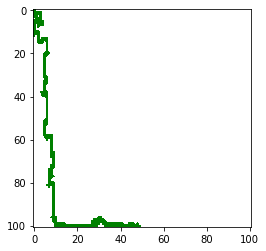

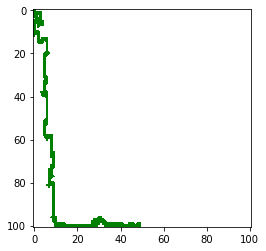

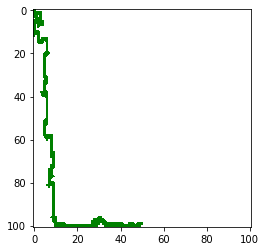

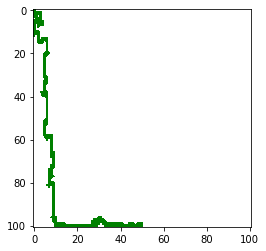

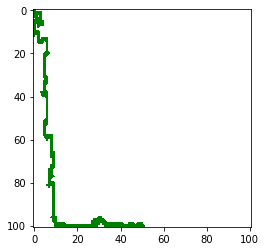

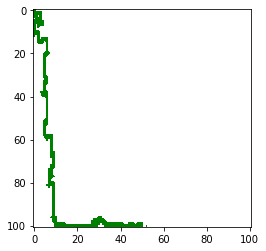

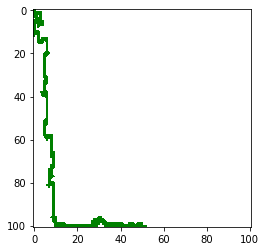

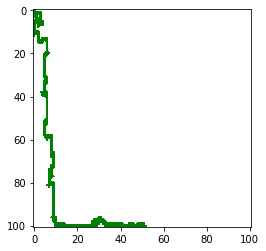

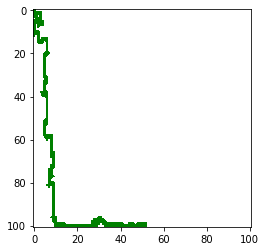

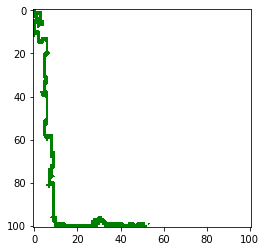

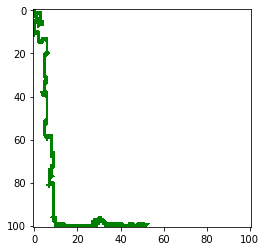

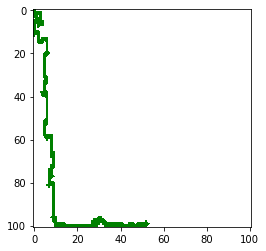

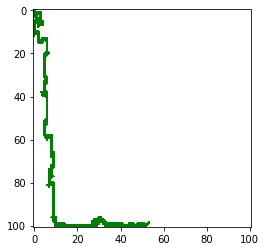

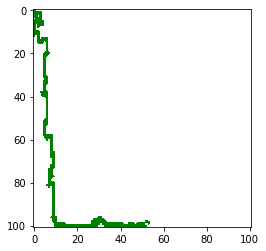

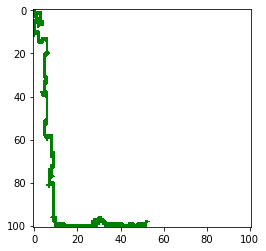

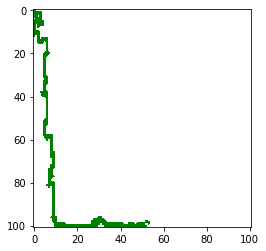

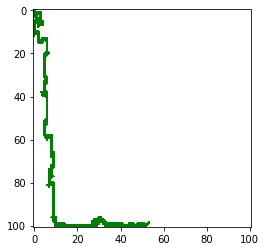

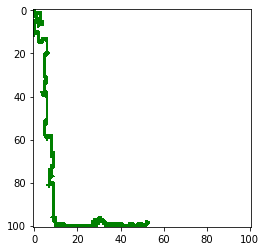

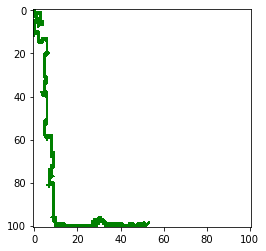

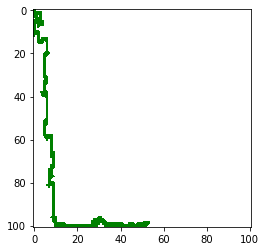

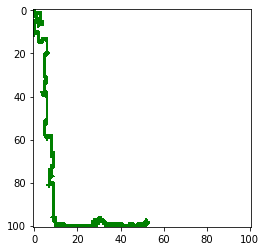

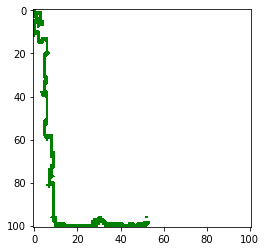

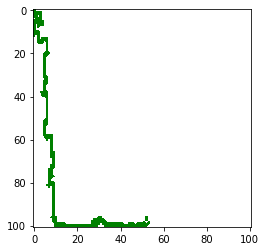

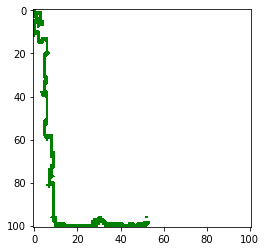

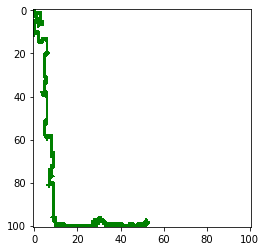

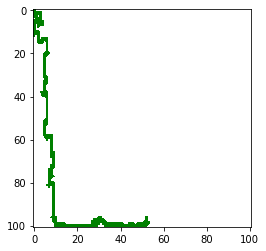

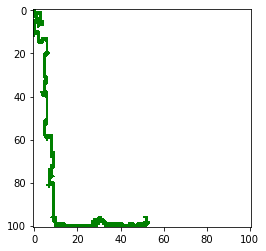

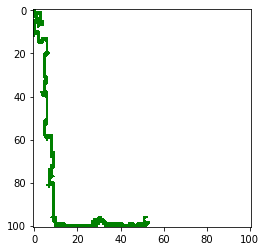

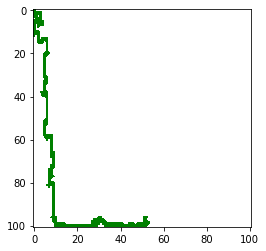

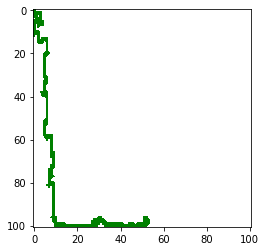

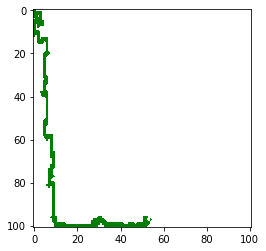

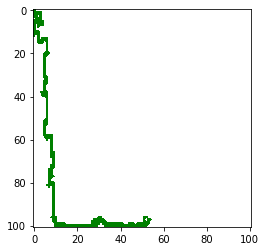

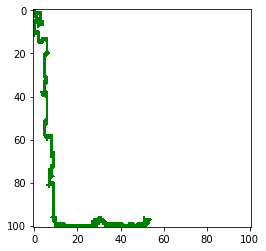

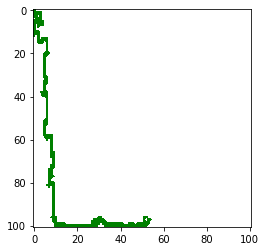

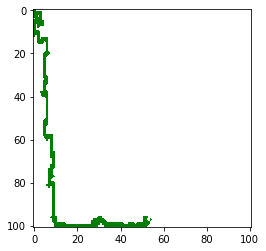

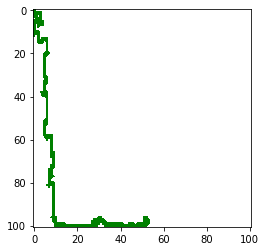

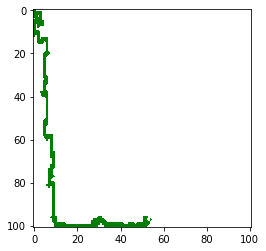

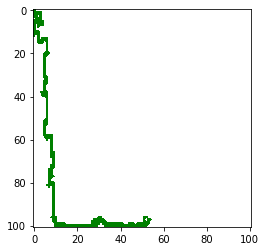

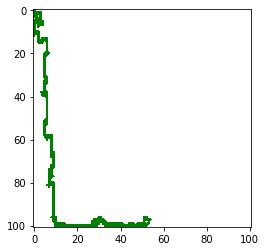

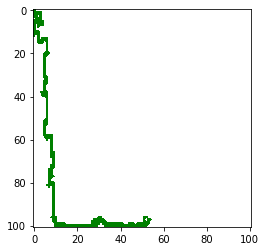

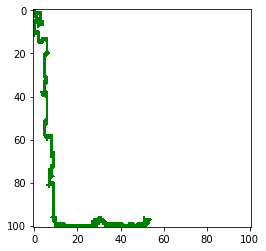

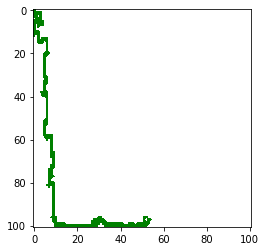

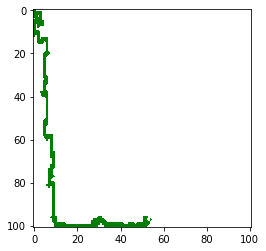

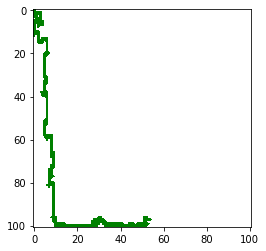

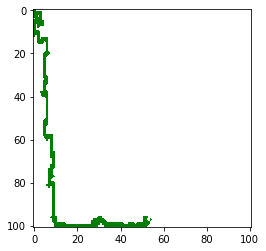

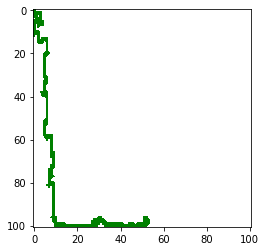

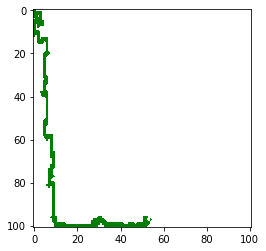

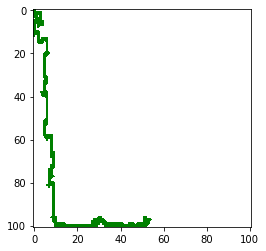

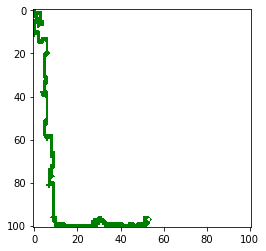

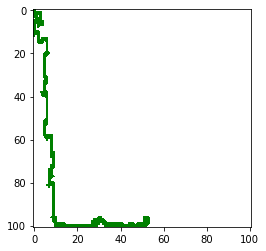

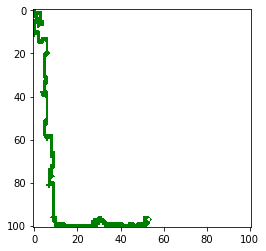

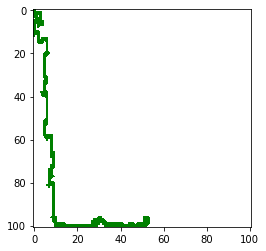

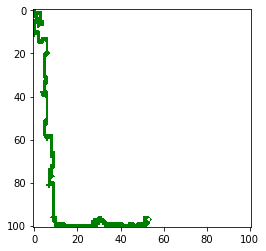

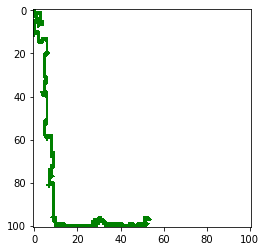

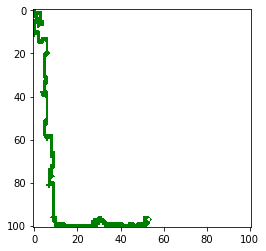

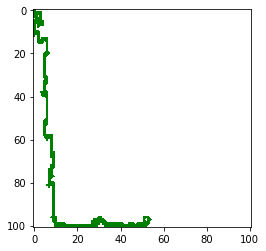

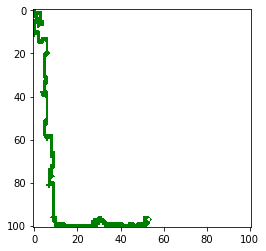

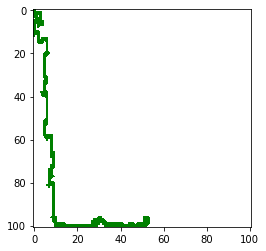

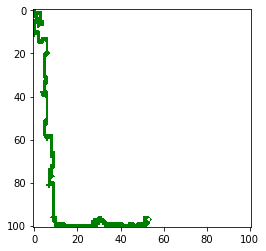

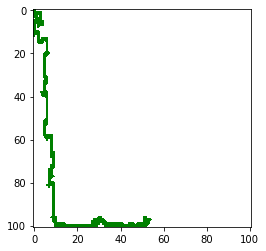

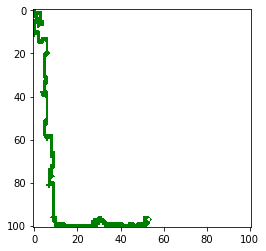

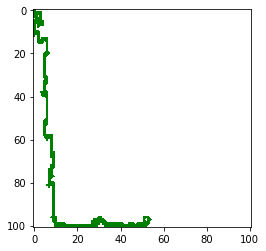

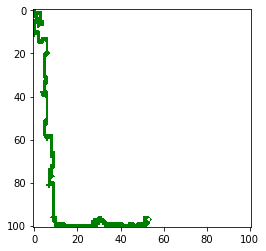

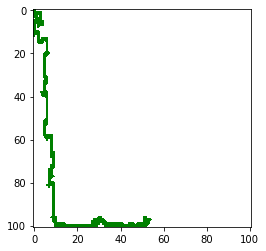

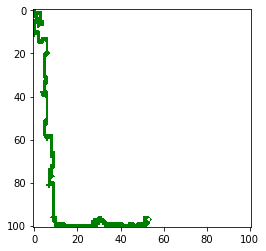

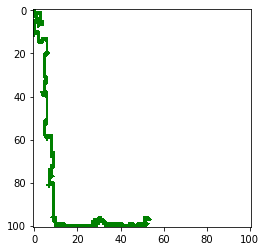

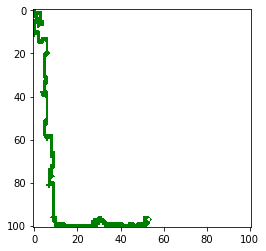

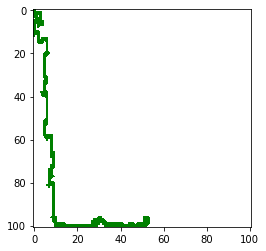

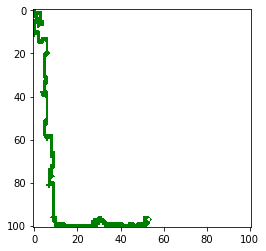

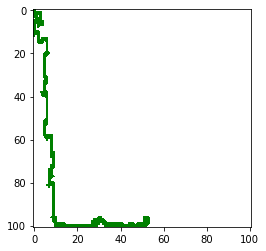

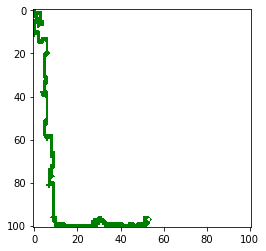

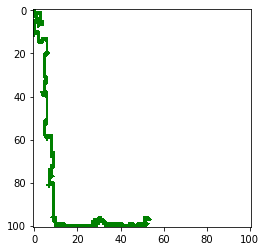

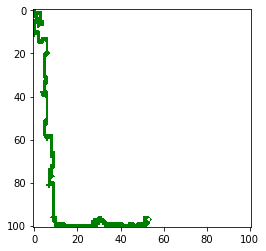

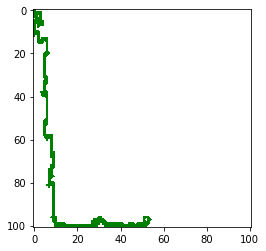

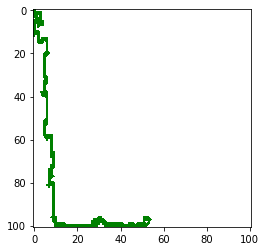

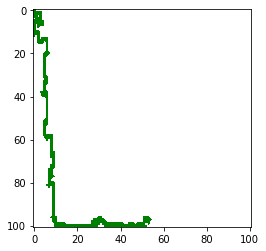

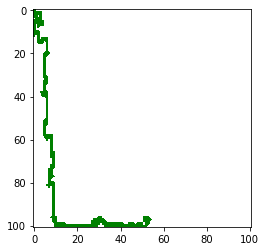

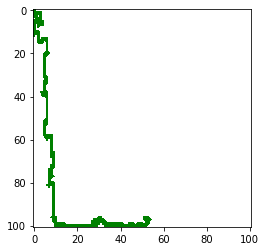

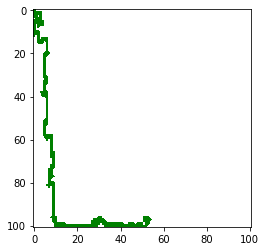

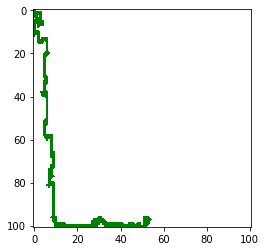

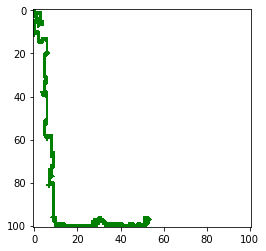

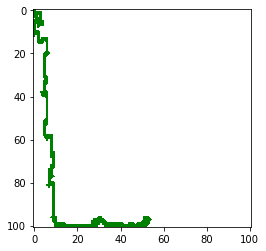

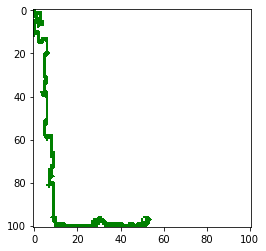

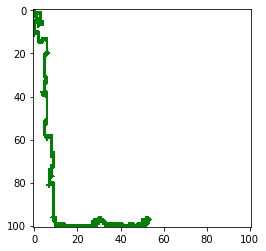

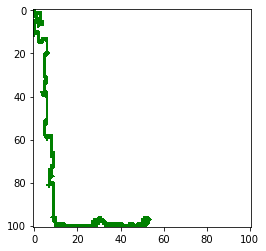

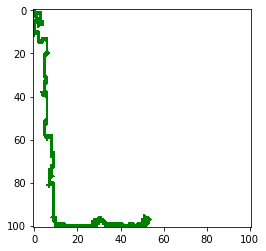

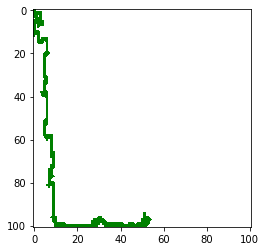

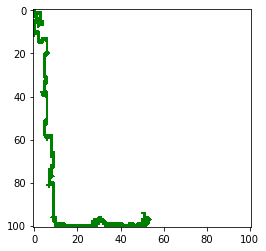

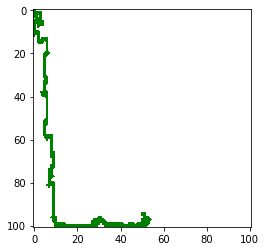

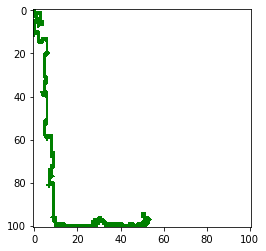

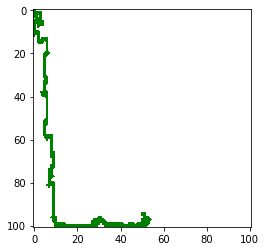

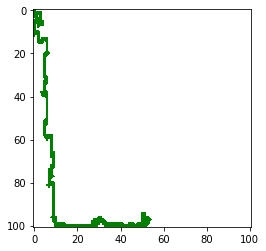

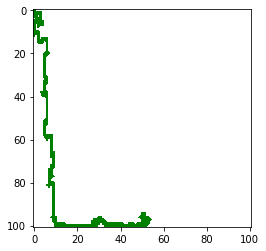

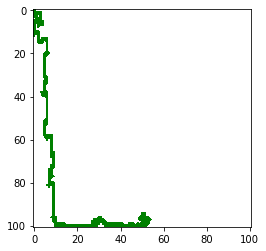

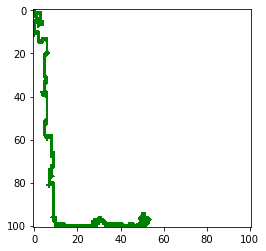

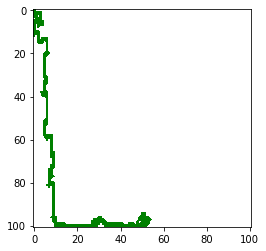

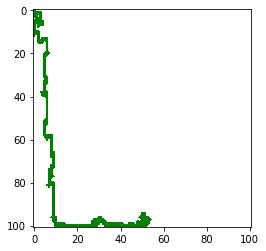

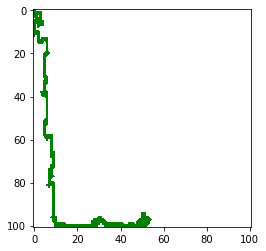

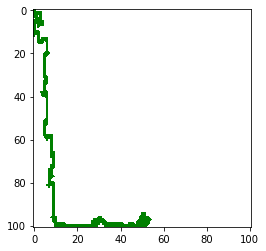

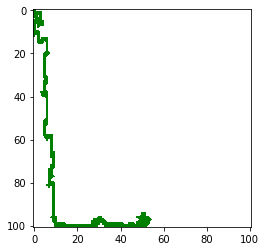

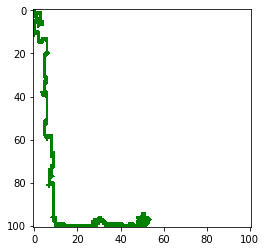

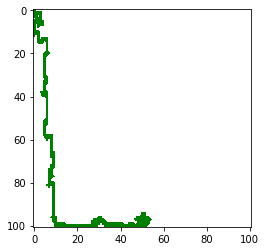

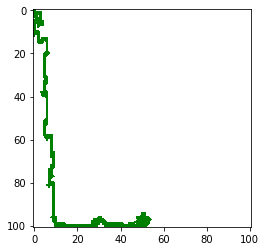

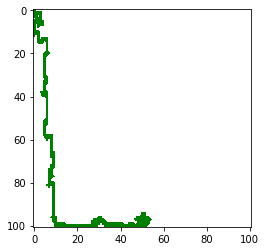

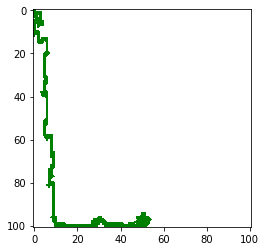

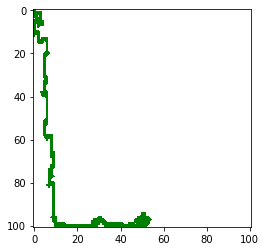

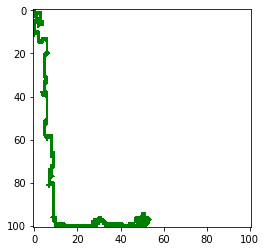

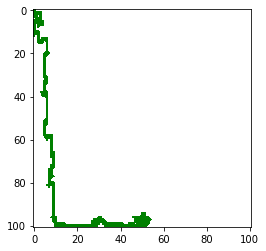

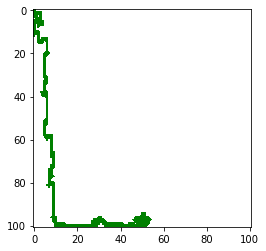

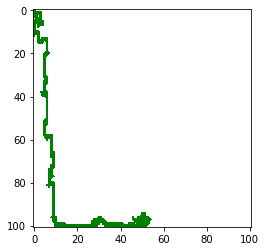

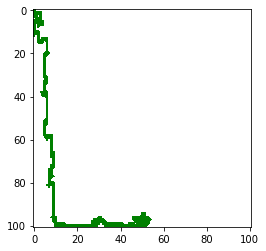

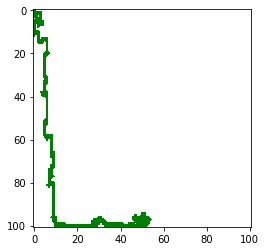

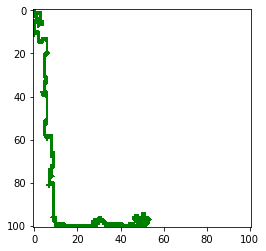

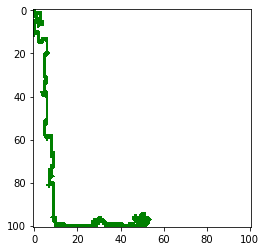

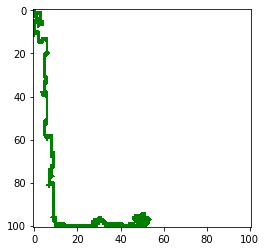

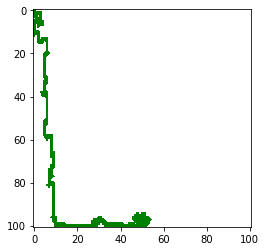

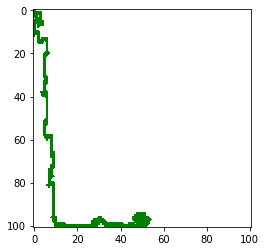

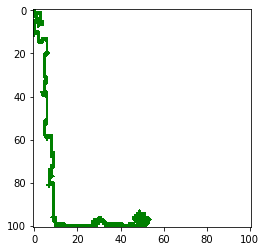

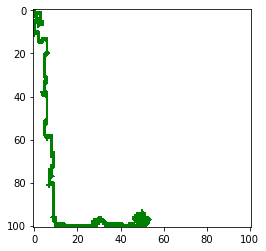

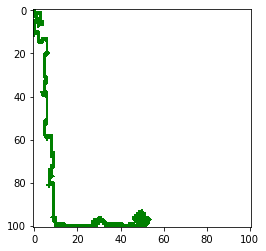

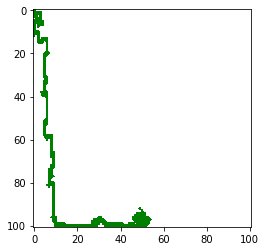

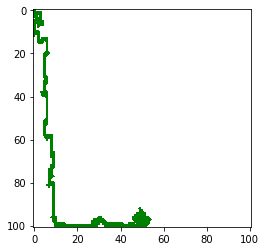

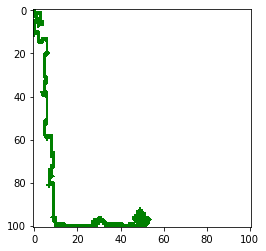

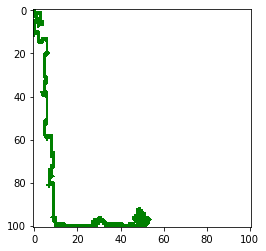

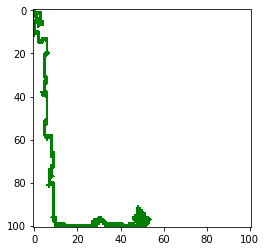

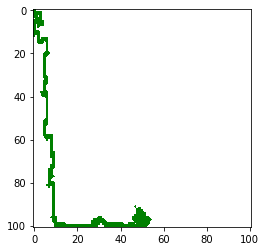

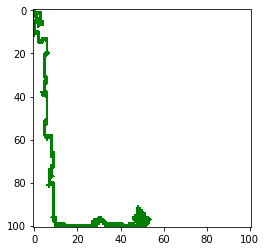

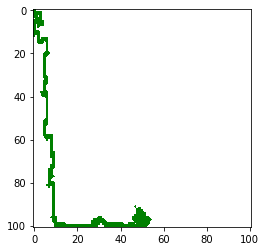

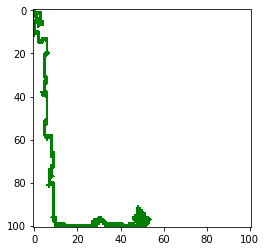

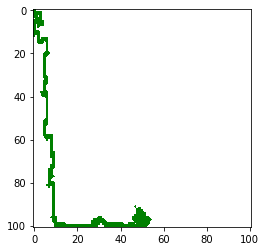

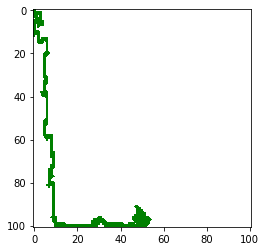

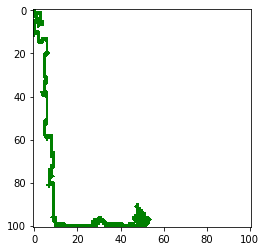

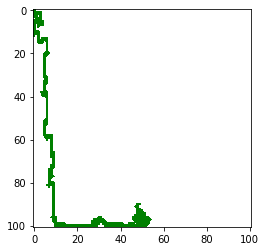

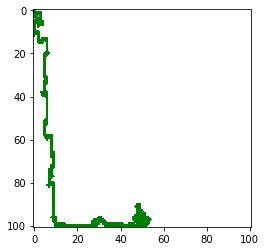

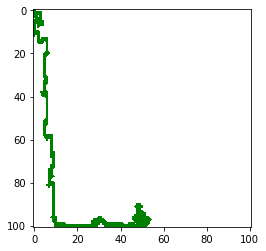

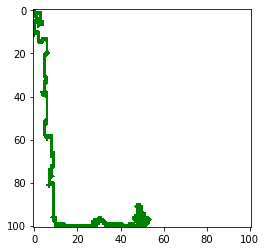

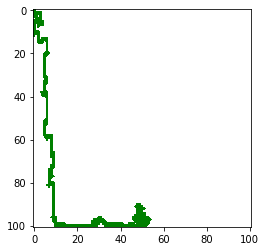

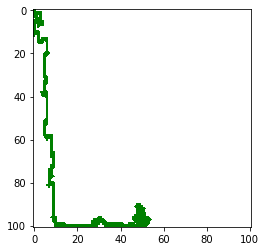

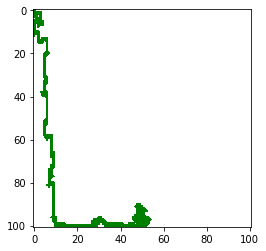

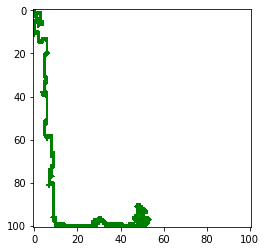

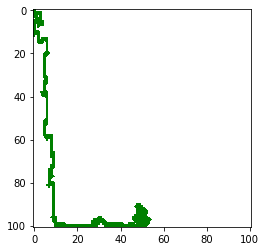

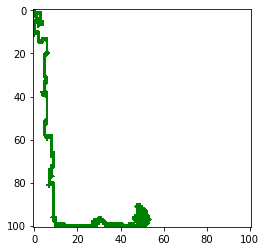

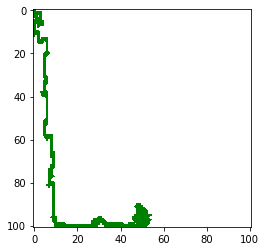

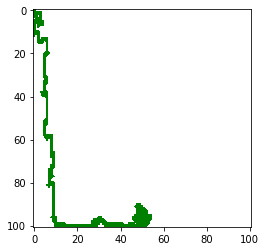

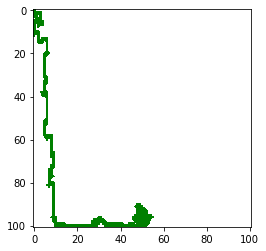

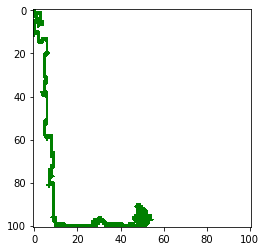

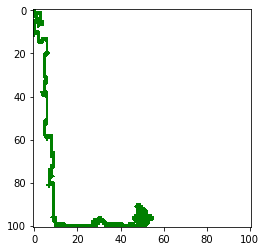

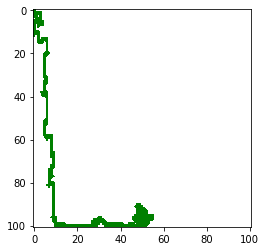

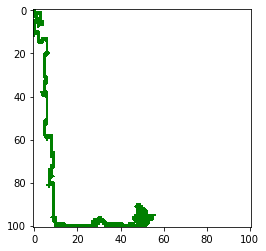

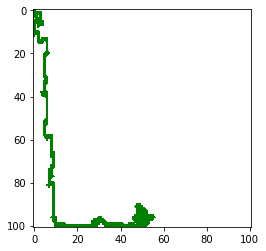

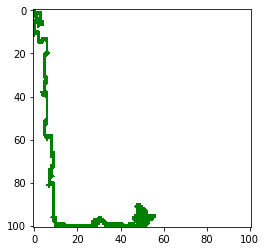

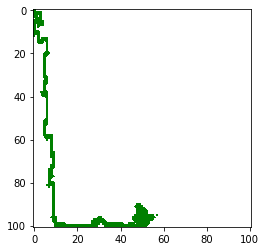

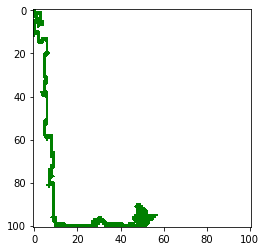

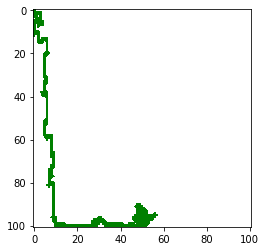

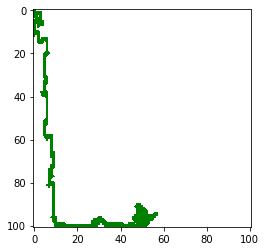

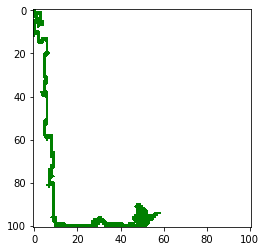

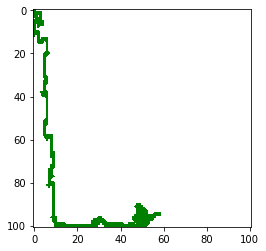

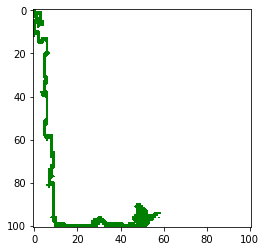

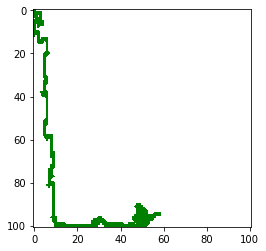

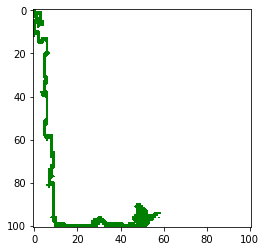

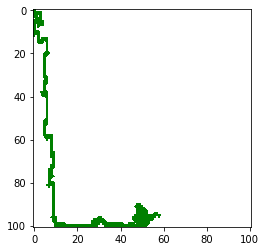

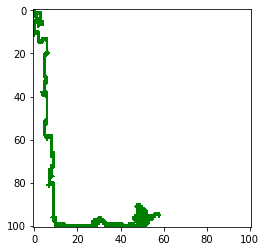

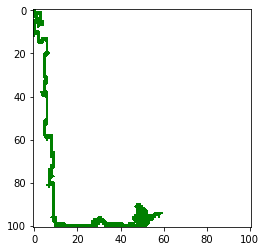

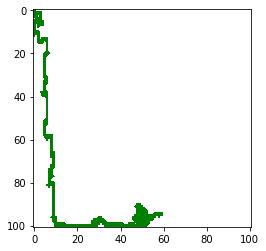

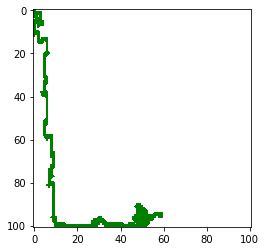

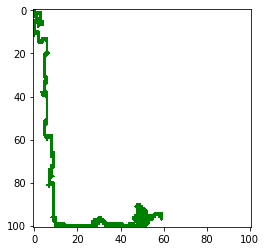

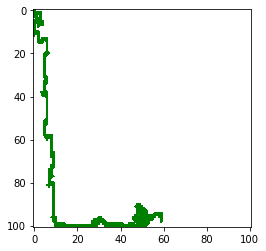

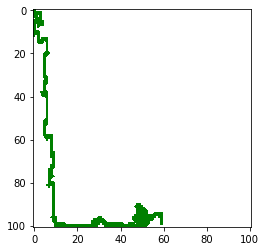

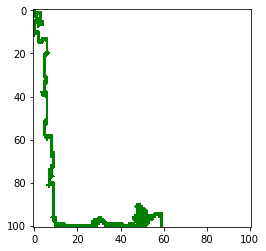

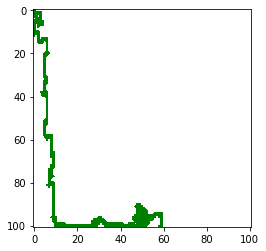

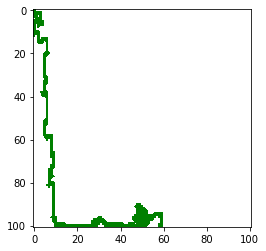

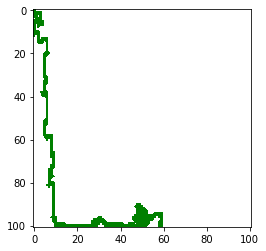

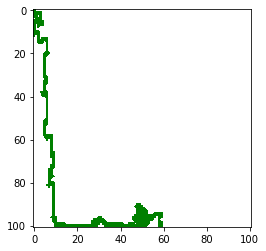

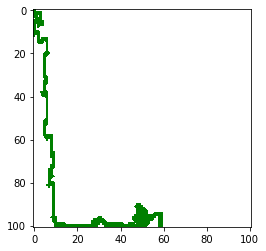

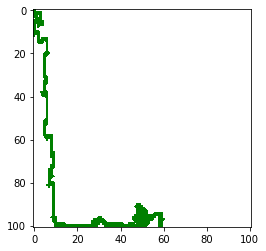

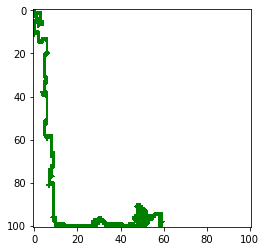

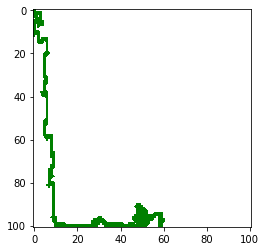

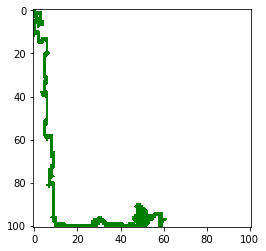

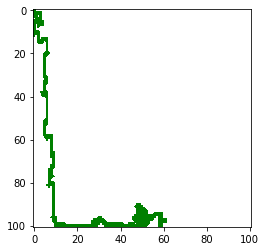

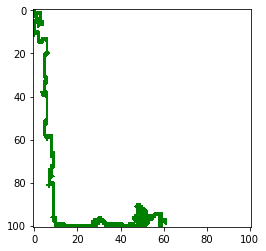

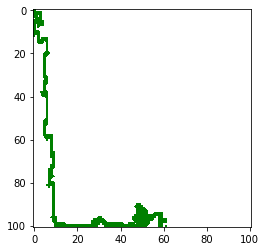

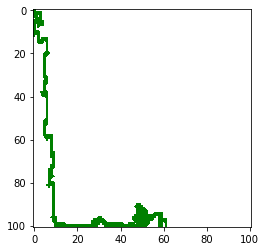

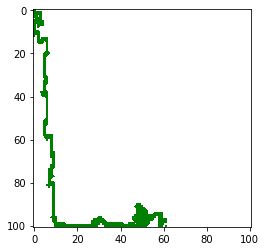

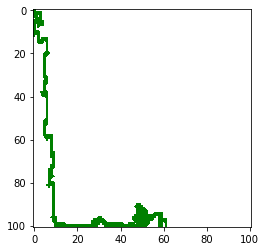

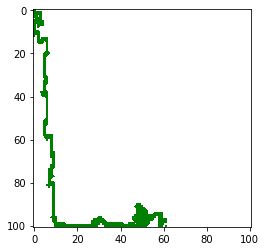

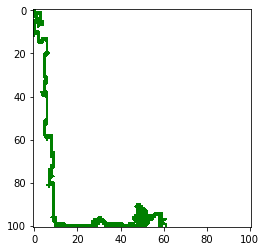

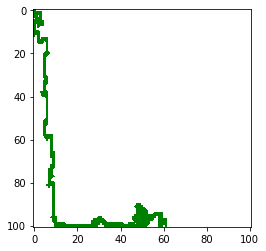

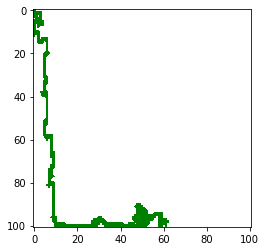

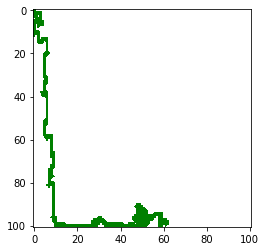

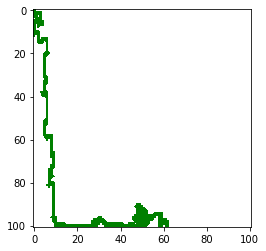

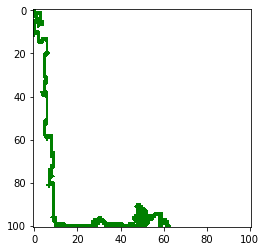

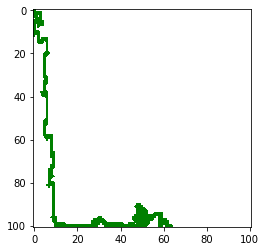

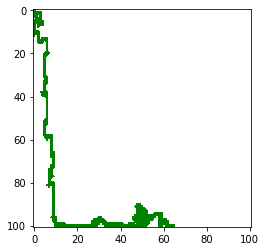

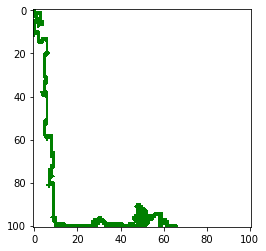

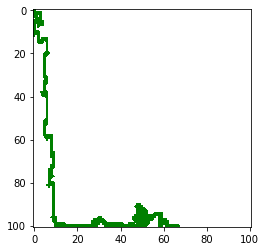

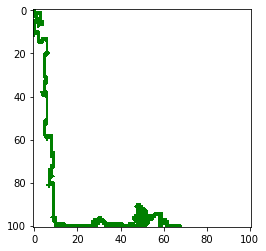

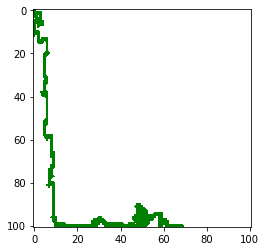

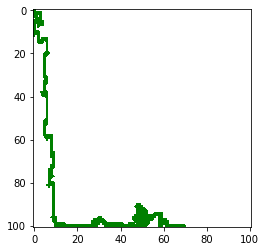

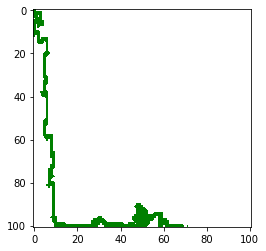

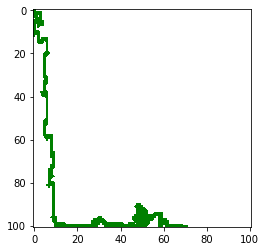

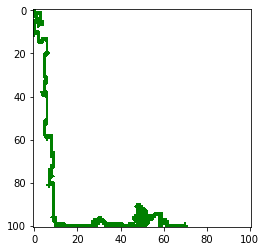

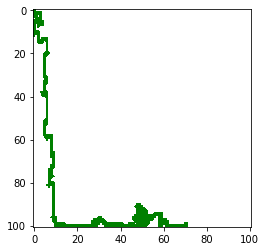

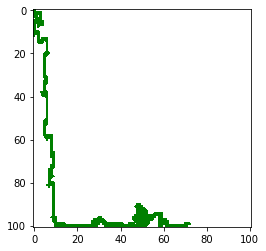

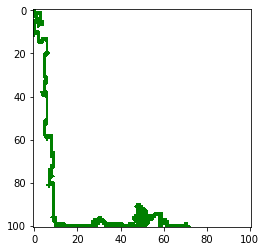

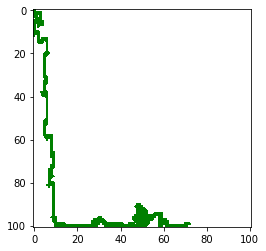

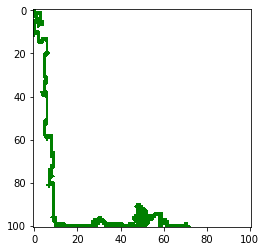

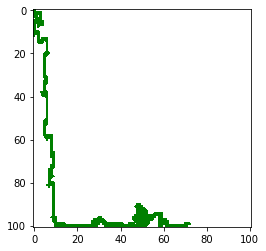

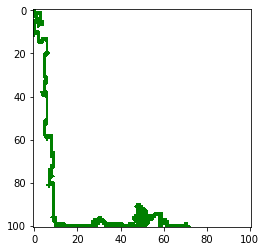

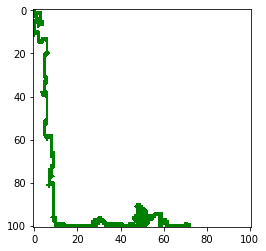

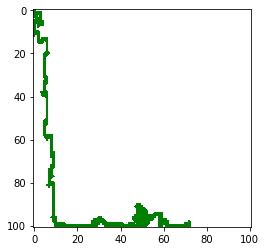

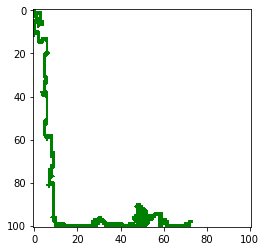

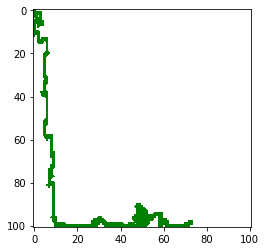

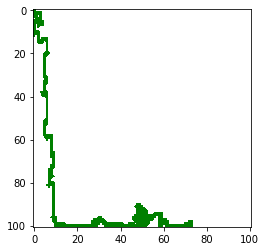

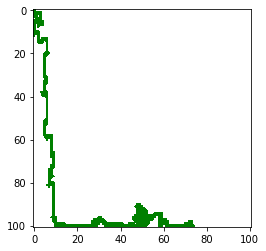

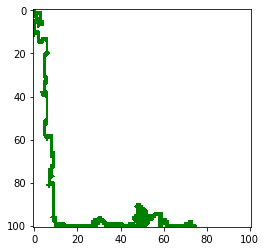

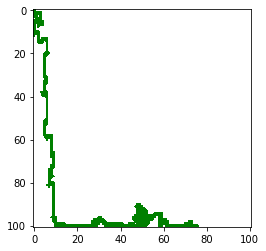

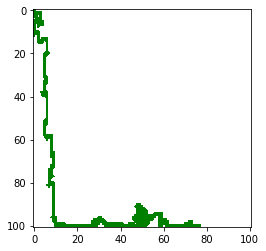

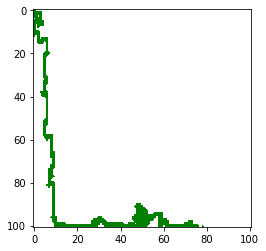

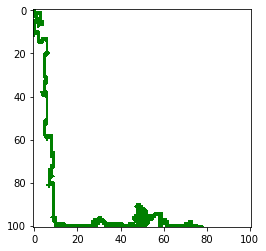

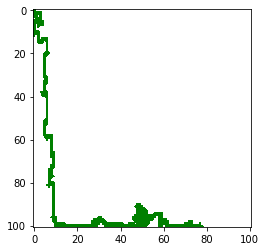

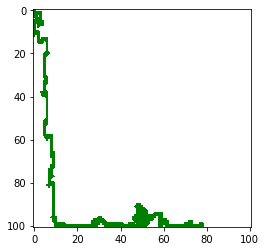

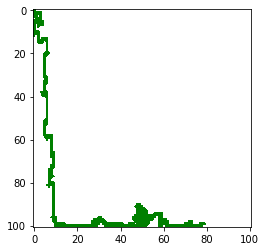

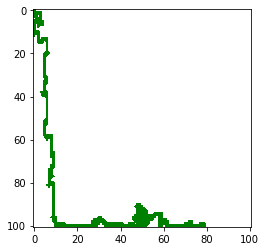

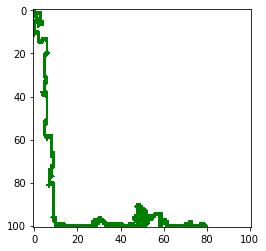

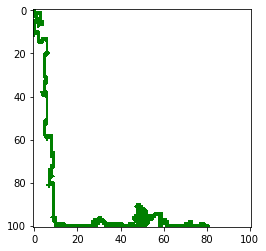

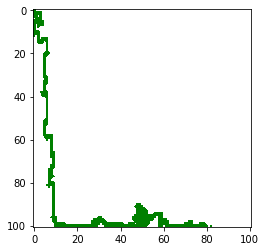

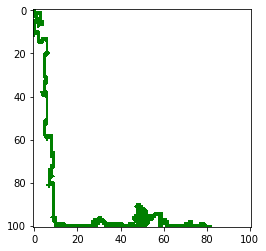

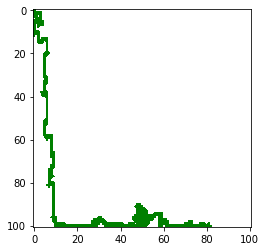

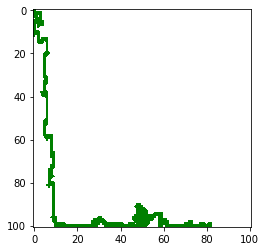

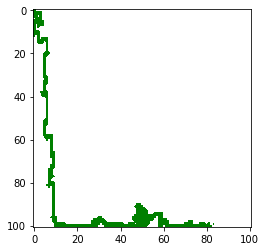

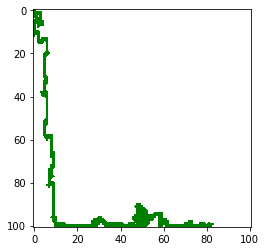

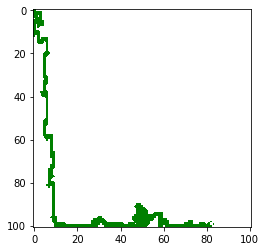

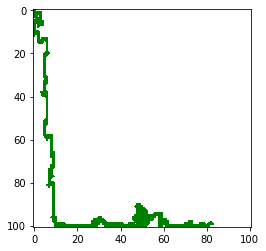

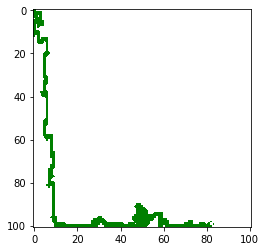

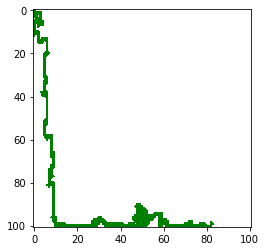

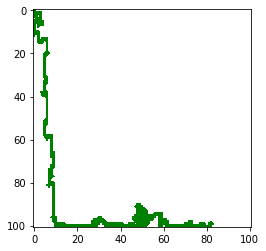

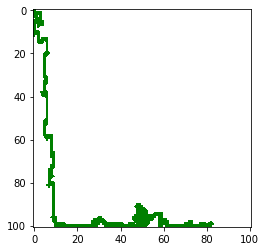

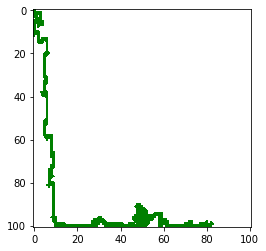

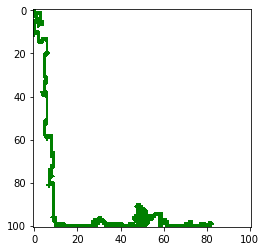

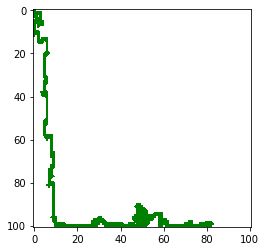

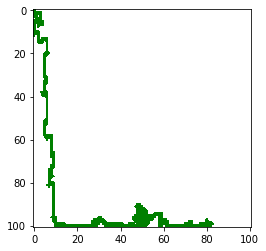

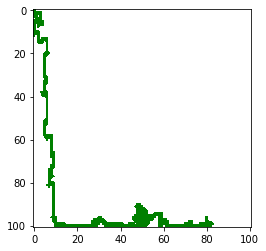

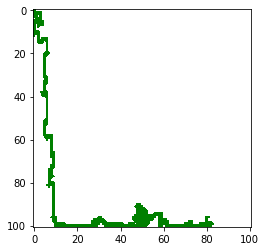

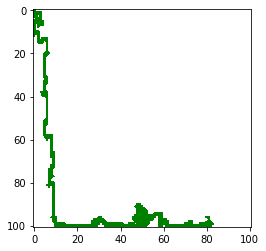

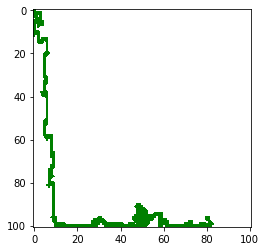

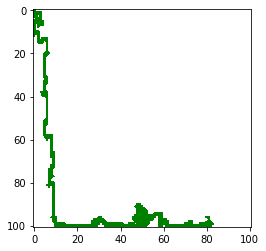

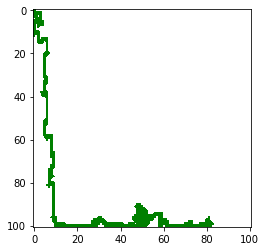

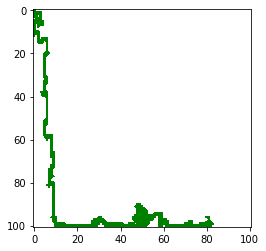

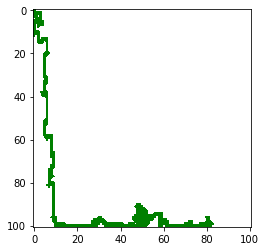

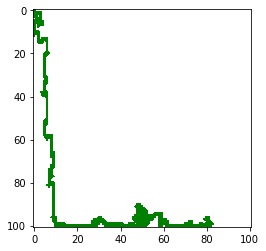

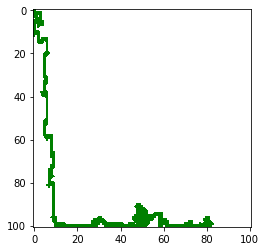

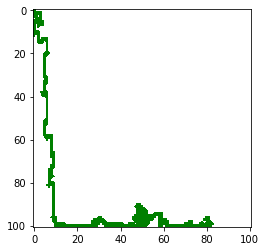

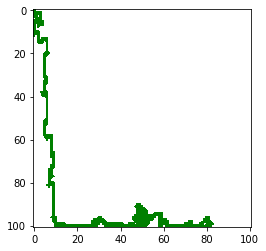

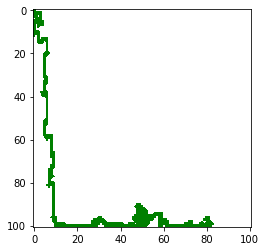

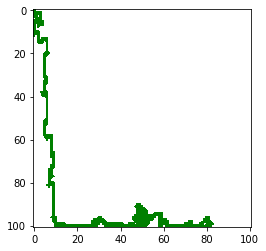

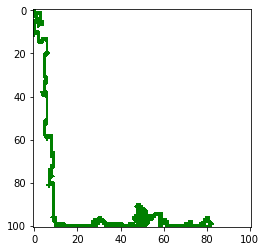

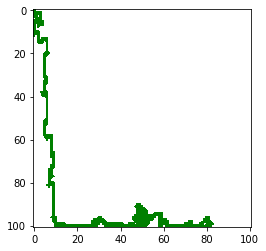

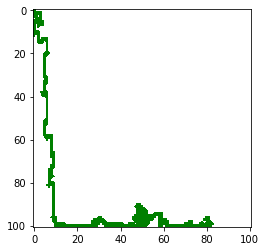

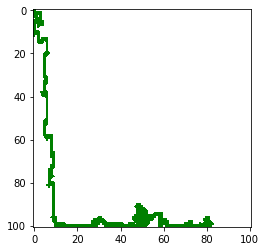

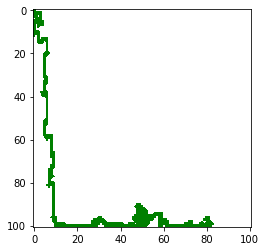

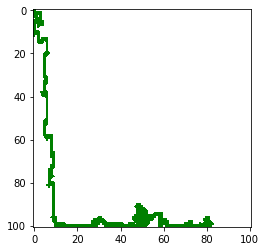

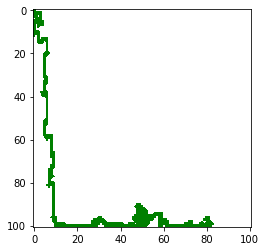

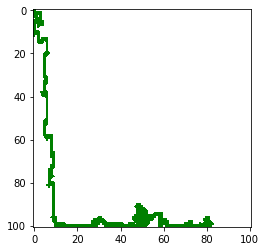

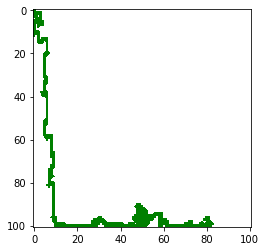

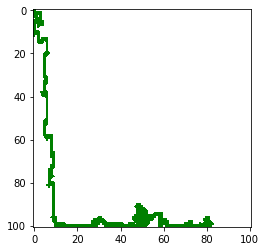

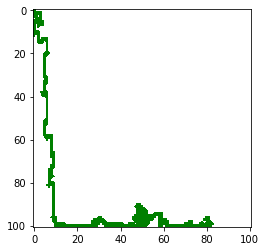

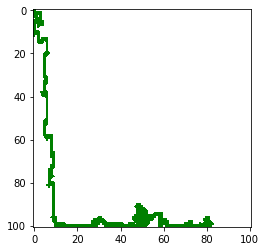

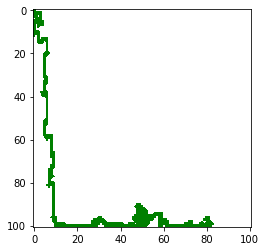

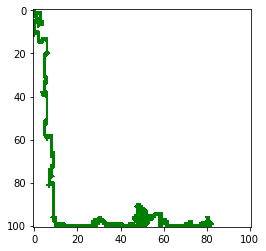

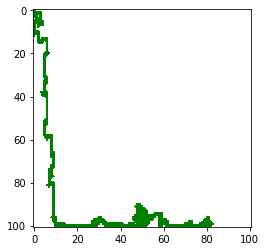

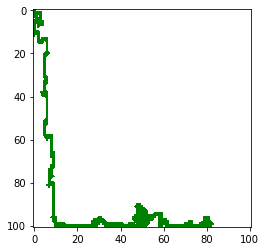

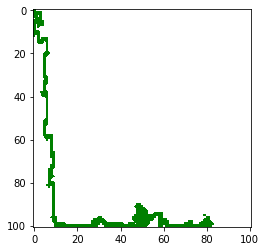

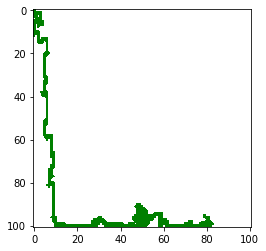

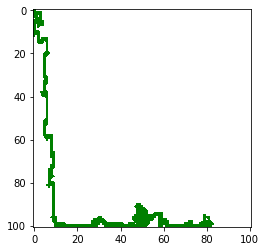

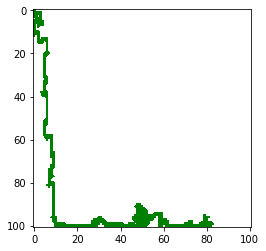

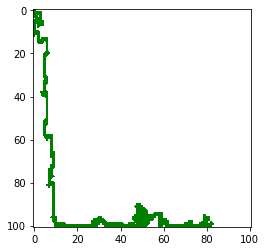

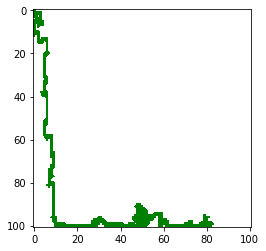

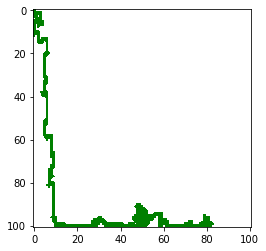

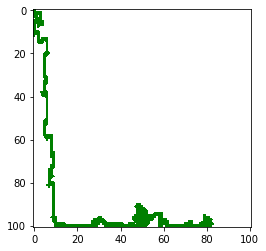

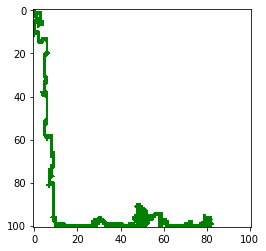

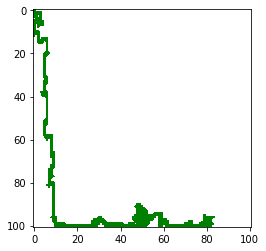

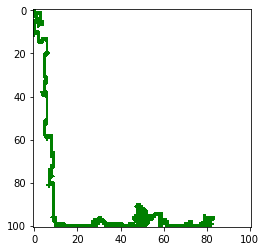

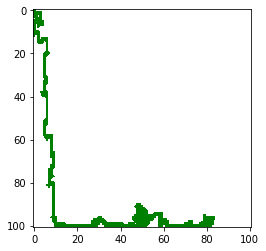

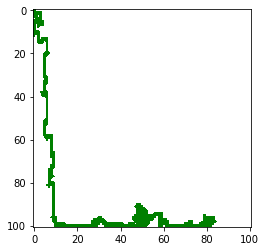

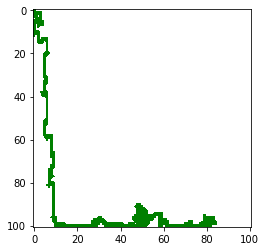

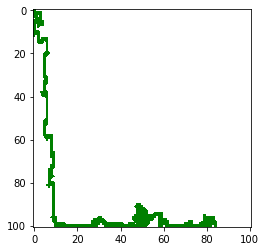

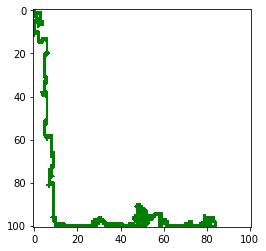

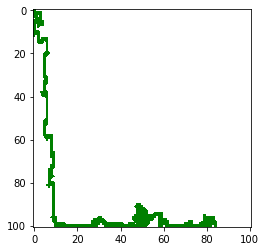

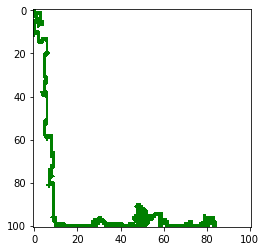

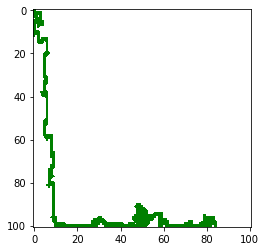

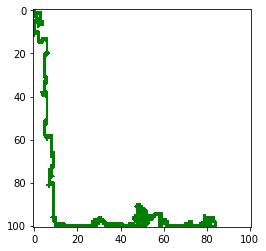

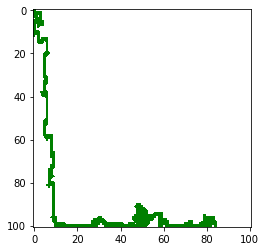

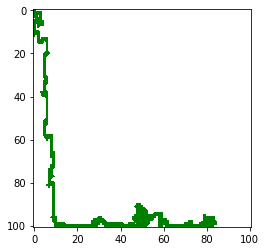

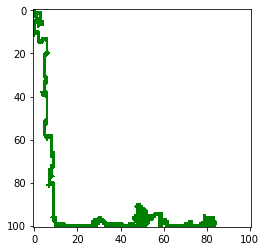

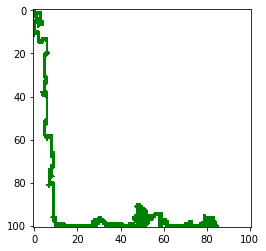

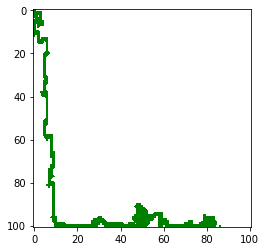

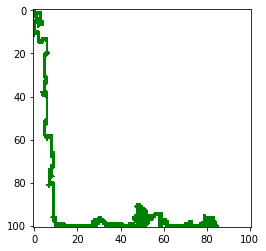

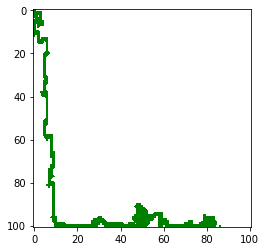

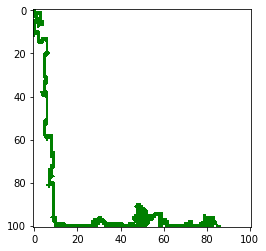

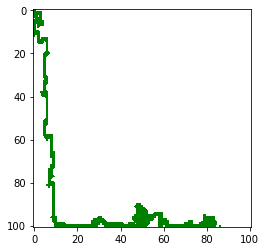

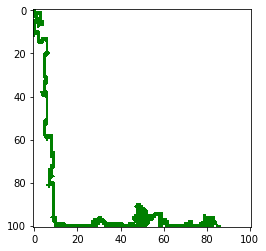

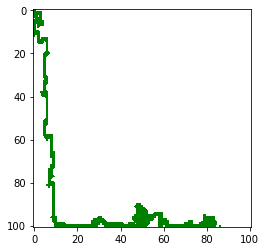

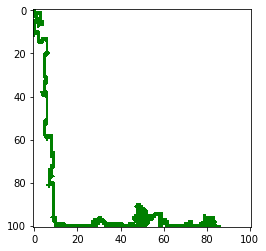

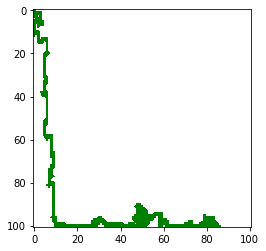

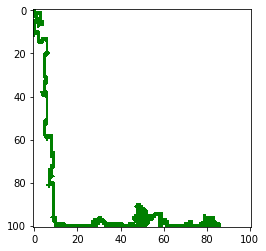

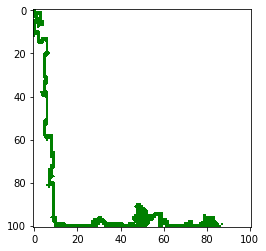

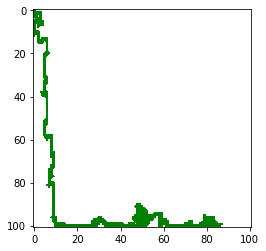

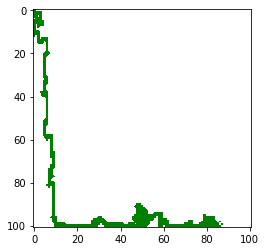

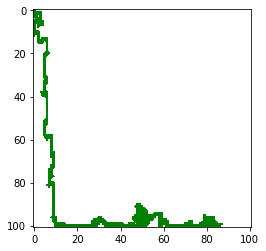

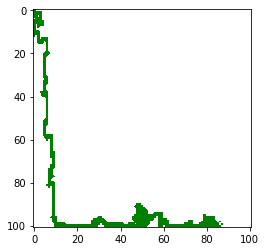

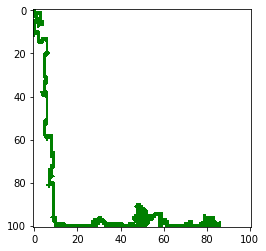

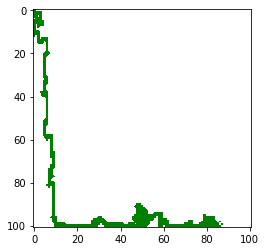

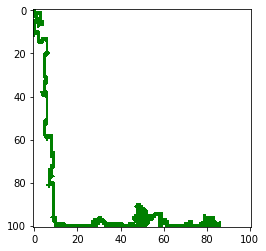

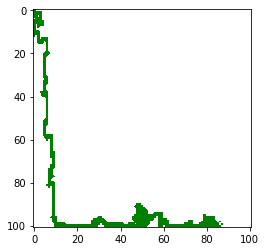

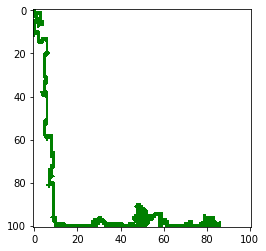

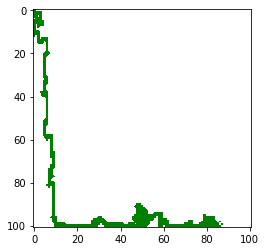

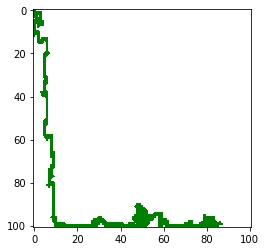

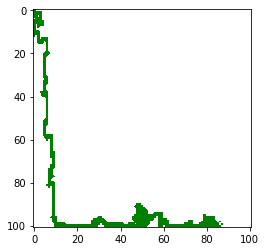

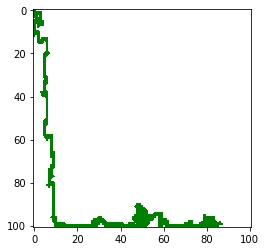

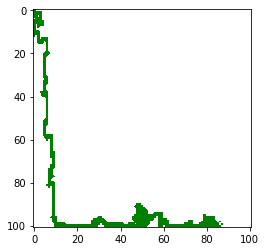

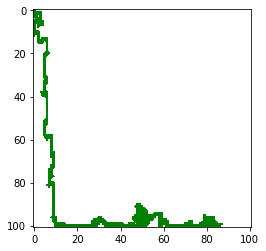

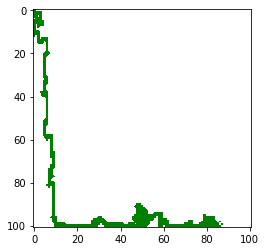

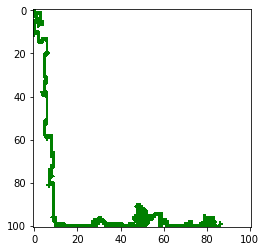

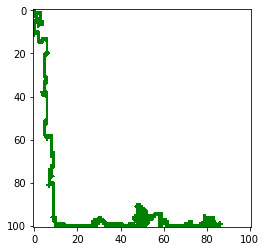

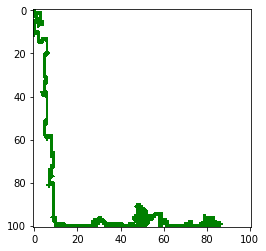

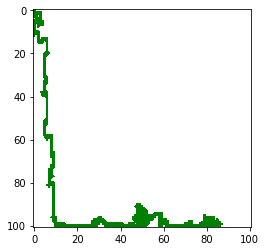

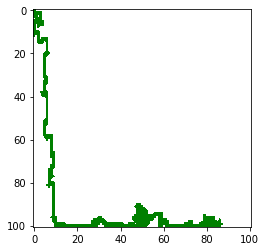

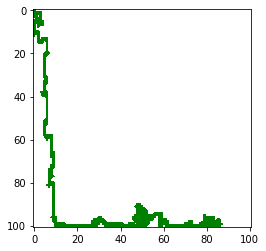

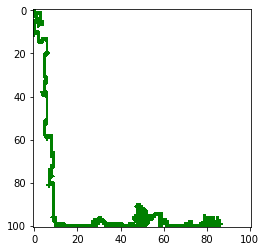

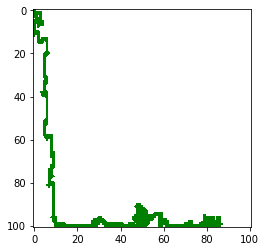

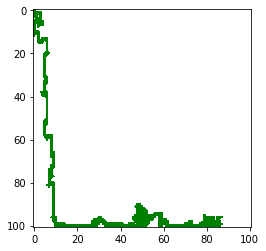

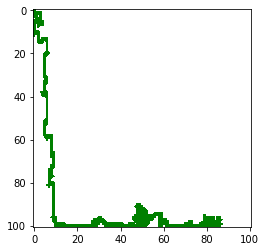

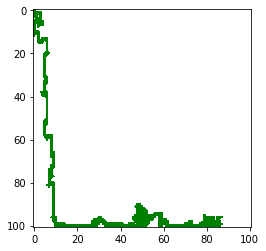

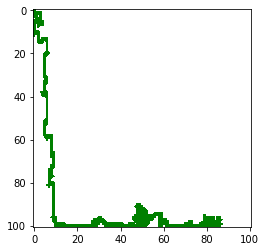

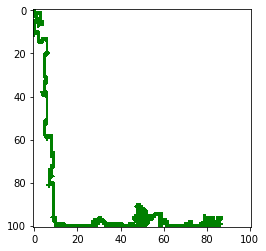

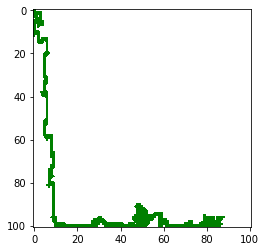

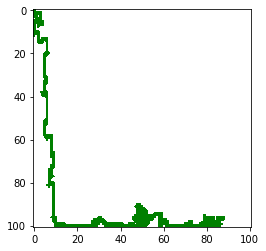

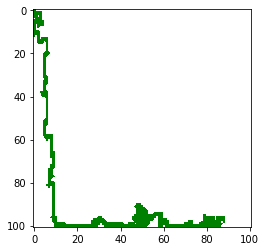

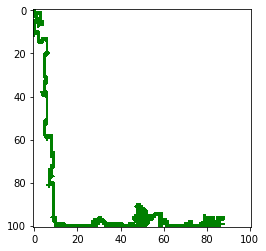

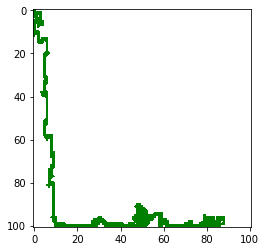

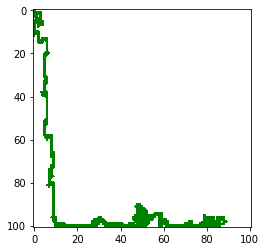

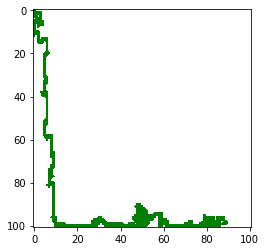

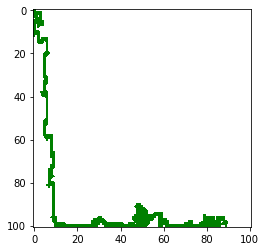

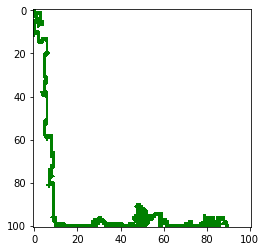

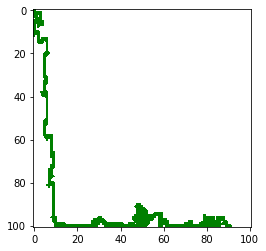

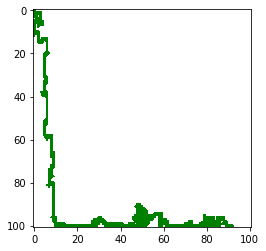

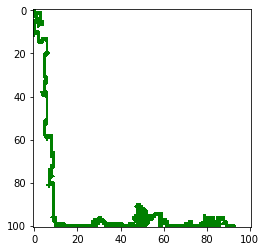

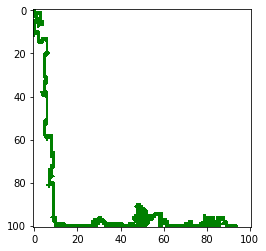

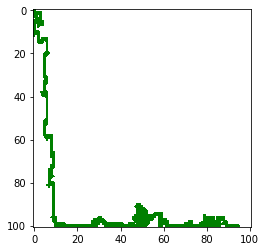

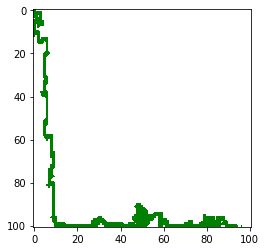

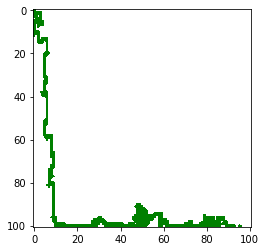

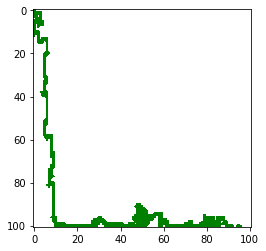

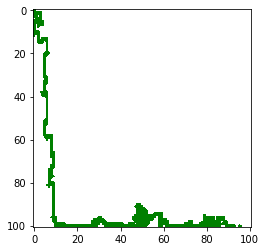

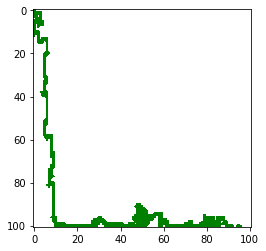

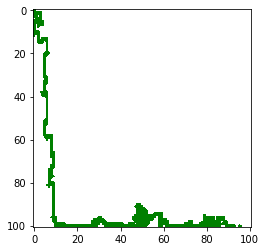

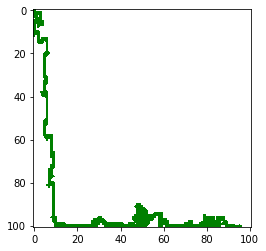

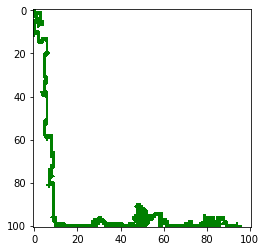

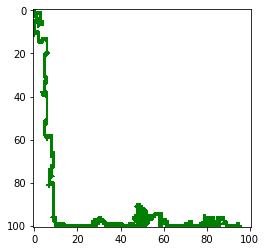

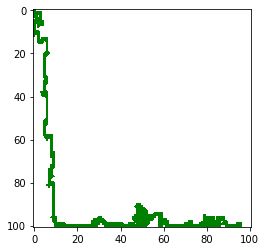

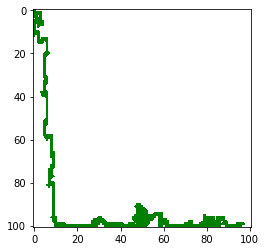

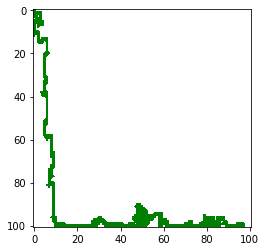

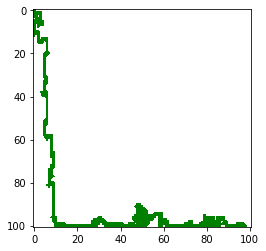

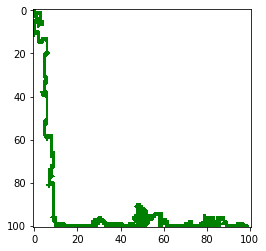

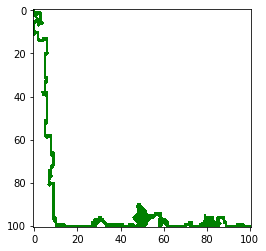

Goal reached!!!
Trajectory length: 437


In [17]:
goal_reached = False
new_model = tf.keras.models.load_model('epic_num_reader.model')

start = (0,0)
goal = (maze_size-1, maze_size-1)
agent_grid_world.itemset(start, 4)
current_node = start
visited_list = []
trajectory = []

while goal_reached == False:
    trajectory.append(current_node)
    agent_grid_world.itemset(current_node, 4)
    if current_node == goal:
        agent_grid_world.itemset(current_node, 1)
        colormap = colors.ListedColormap(["green","white"])
        plt.imshow(agent_grid_world, cmap=colormap)
        plt.show()
        print('Goal reached!!!')
        goal_reached = True
        break

    if current_node not in visited_list:
        visited_list.append(current_node)

    x_test = get_window(current_node, agent_grid_world, full_grid_world)
    x_test = np.asarray(x_test)

    predictions = new_model.predict(np.asarray([x_test]))

    if full_grid_world.item(current_node) == 1:
        agent_grid_world.itemset(current_node, 2)
        flag = 'blocked'
    else:
        agent_grid_world.itemset(current_node, 1)
        flag = 'free'
    
    if flag == 'free':
        try:
            next_node, message = next_move(current_node, predictions, full_grid_world, visited_list, maze_size, trajectory, flag, agent_grid_world)
            current_node = next_node
        except Exception as err:
            print(err)
            print('No path to goal')
            break
        if message == "Can't reach goal":
            print('Cannot reach goal')
            break

    if flag == 'blocked':
        current_node = trajectory[-2]

    agent_grid_world.itemset(current_node, 4)
    colormap = colors.ListedColormap(["green","white"])
    plt.imshow(agent_grid_world, cmap=colormap)
    plt.show()
print("Trajectory length:", len(trajectory))

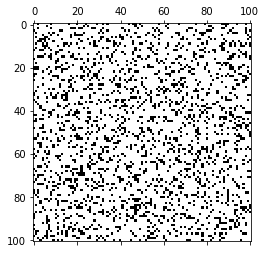

In [18]:
plt.spy(full_grid_world)

In [20]:
model.save('epic_num_reader.model')

INFO:tensorflow:Assets written to: epic_num_reader.model\assets
